# Méthode du synthetic control pour mesurer l'effet des "incentives" à la vaccination aux États-Unis
## Version simplifiée (synthetic control uniquement)

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

# On supprime le New Hampshire à cause d'irrégularités dans ses données vaccinales

states_names = {"AL":"Alabama", "AK":"Alaska", "AZ":"Arizona", "AR":"Arkansas",
                "CA":"California", "CO":"Colorado", "CT":"Connecticut",
                "DE":"Delaware", "FL":"Florida", "GA":"Georgia", "HI":"Hawaii",
                "ID":"Idaho", "IL":"Illinois", "IN":"Indiana", "IA":"Iowa",
                "KS":"Kansas", "KY":"Kentucky", "LA":"Louisiana", "ME":"Maine",
                "MD":"Maryland", "MA":"Massachusetts", "MI":"Michigan",
                "MN":"Minnesota", "MS":"Mississippi", "MO":"Missouri", "MT":"Montana",
                "NE":"Nebraska", "NV":"Nevada", "NH":"New Hampshire", "NJ":"New Jersey",
                "NM":"New Mexico", "NY":"New York", "NC":"North Carolina",
                "ND":"North Dakota", "OH":"Ohio", "OK":"Oklahoma", "OR":"Oregon",
                "PA":"Pennsylvania", "RI":"Rhode Island", "SC":"South Carolina",
                "SD":"South Dakota", "TN":"Tennessee", "TX":"Texas", "UT":"Utah",
                "VT":"Vermont", "VA":"Virginia", "WA":"Washington", "WV":"West Virginia",
                "WI":"Wisconsin", "WY":"Wyoming"}

In [26]:
df_states = {}
for X in states:
  # fichiers csv à trouver dans le drive partagé
    path = 'state_vax_csv/'+X+'.csv'
    df_states[X] = pd.read_csv(path, sep=',')
    df_states[X] = df_states[X].loc[::-1].reset_index(drop=True)
    df_states[X] = df_states[X].loc[67:,:].reset_index(drop=True)

In [27]:
# On remarque qu'il y a des problèmes dans le report des doses administrées : il arrive que le pourcentage de doses
# administrées diminue, alors qu'il ne devrait qu'augmenter ou rester constant (cf. explications dans le rapport)
# On décide donc de remédier à ces erreurs en fixant un seuil pour éviter que les données ne diminuent
# Dans un second temps, on effectue une interpolation sur la période où l'on constate des erreurs de report

tf = len(df_states['CA'])

for seg in ["Administered_Dose1_Pop_Pct", "Administered_Dose1_Recip_12_17_Pct", "Administered_Dose1_Recip_18_64_Pct", "Administered_Dose1_Recip_65PlusPop_Pct"]:
    for state in states:
        for t in range(1,tf):
            if df_states[state].loc[t, seg] < df_states[state].loc[t-1, seg]:
                #on a un souci à partir du temps t
                j = t
                flag = True
                while j < tf and flag:
                    if df_states[state].loc[j, seg] >= df_states[state].loc[t-1, seg]:
                        #on a trouvé le plus petit indice pour lequel les données redeviennent cohérentes
                        a_t = df_states[state].loc[t-1, seg]
                        a_j = df_states[state].loc[j, seg]
                        
                        #on interpole linéairement
                        for i in range(t,j):
                            df_states[state].loc[i, seg] = ((a_t-a_j)/(t-1-j))*(i-j) + a_j
                        flag = False
                    j +=1 
                        
                if flag:
                    #on a pas trouvé de plus petit indice: on crée un plateau à partir du temps t
                    for i in range(t,tf):
                        df_states[state].loc[i, seg] = df_states[state].loc[t-1, seg]

In [28]:
# On s'intéresse à la colonne du pourcentage de personnes ayant reçu au moins une dose. 
# C'est notre "response variable" que l'on cherche à modéliser après l'intervention.

df_dose1 = {"Pop":{} ,"12-17":{}, "18-64":{}, "65Plus":{}}
df_admin = {}

for X in states:
    df_dose1["Pop"][X] = df_states[X].loc[:,'Administered_Dose1_Pop_Pct']
    df_dose1["12-17"][X] = df_states[X].loc[:,'Administered_Dose1_Recip_12_17_Pct']
    df_dose1["18-64"][X] = df_states[X].loc[:,'Administered_Dose1_Recip_18_64_Pct']
    df_dose1["65Plus"][X] = df_states[X].loc[:,'Administered_Dose1_Recip_65PlusPop_Pct']
    df_admin[X] = df_states[X].loc[:,'Admin_Per_100K']

ls_dose1 = {"Pop":{} ,"12-17":{}, "18-64":{}, "65Plus":{}}
for k in ["Pop", "12-17", "18-64", "65Plus"]:
    for X in states:
        ls_dose1[k][X] = df_dose1[k][X].to_numpy()

In [29]:
df_prm = pd.read_excel('parameters.xlsx', 'By state code', index_col=0)
df_prm = df_prm.drop(columns=['Population'])
prm = df_prm.to_numpy()
    
state_vector = {}
for i in range(len(states)):
    state_vector[states[i]] = prm[i]

In [30]:
# Normalisation et moyenne à 0

df_prm_scaled = (df_prm-df_prm.mean())/df_prm.std()
prm_scaled = df_prm_scaled.to_numpy()

state_vector_scaled = {}
for i in range(len(states)):
    state_vector_scaled[states[i]] = prm_scaled[i]

In [31]:
incentives = pd.read_csv('incentive_list_updated.csv', index_col=None)

target_states_all = sorted(set(incentives["State code"]))
control_states_all = []
for X in states:
  if X not in target_states_all:
    control_states_all.append(X)
    
control_states_names = [states_names[X] for X in control_states_all]

In [32]:
dates = {}
category = {}
for X in target_states_all:
    dates[X] = incentives.loc[incentives["State code"] == X, "Incentive t0"]
    dates[X] = dates[X].iloc[0]

In [33]:
import datetime
inc_t0 = {}
inc_t0["Pop"] = {}
inc_t0["18-64"] = {}
inc_t0["65Plus"] = {}

for X in target_states_all:
  # 19/02/2021 approx première date à laquelle les taux de vaccination sont non nuls
  start = datetime.date(2021,2,19)
  t0_date_str = dates[X]
  t0_date = datetime.date(int(t0_date_str[6:]), int(t0_date_str[3:5]), int(t0_date_str[0:2]))
  t0 = t0_date - start
  t0 = t0.days
  inc_t0["Pop"][X] = t0
  inc_t0["18-64"][X] = t0
  inc_t0["65Plus"][X] = t0

In [34]:
def norm(w, v, x, x1):
    pred = np.dot(np.transpose(x), w)
    pred_diff = x1 - pred
    pred_diff_v = np.multiply(pred_diff, v)
    res = np.dot(pred_diff, pred_diff_v)
    return np.sqrt(res)

L1 = 0.6
L2 = 0.1

def norm_reg(w, v, x, x1):
    pred = np.dot(np.transpose(x), w)
    pred_diff = x1 - pred
    pred_diff_v = np.multiply(pred_diff, v)
    res = np.sqrt(np.dot(pred_diff, pred_diff_v))
    res += L1*np.linalg.norm(w)
    res += L2*sum(np.abs(w))
    return res

def mspe(y1, y, w):
    interv = np.dot(np.transpose(y), w)
    interv_diff = y1 - interv
    res = np.dot(interv_diff, interv_diff)
    return res

In [35]:
# Définition des fonctions d'optimisation pour le contrôle synthétique

from scipy.optimize import minimize, fmin_slsqp

def constraint(w, v, x, x1):
    return np.sum(w) - 1

def con(v):
    return np.sum(v) - 1
cons = {'type':'eq', 'fun': con}

def mspe_opt_w(v_guess, w_guess, x, x1, y, y1):
    w_opt = fmin_slsqp(norm_reg, w_guess, f_eqcons=constraint, bounds=[(0.0, 1.0)]*len(w_guess),
             args=(v_guess, x, x1), disp=False)
    return mspe(y1, y, w_opt)

def opt_v(v_guess, w_guess, x, x1, y, y1):
    v_opt = minimize(mspe_opt_w, v_guess, constraints = cons, bounds=[(0.0, 1.0)]*len(v_guess), 
             args=(w_guess, x, x1, y, y1), method='SLSQP')
    return v_opt.x

def opt_w(w_guess, v, x, x1):
    w_opt = fmin_slsqp(norm_reg, w_guess, f_eqcons=constraint, bounds=[(0.0, 1.0)]*len(w_guess),
             args=(v, x, x1), disp=False)
    return w_opt

In [36]:
# Contrôle synthétique

import random

y1_prediction = {}

# dfs={}
# dfs['A'] = pd.DataFrame(columns=control_states['A'])
# dfs['B'] = pd.DataFrame(columns=control_states['B'])
# dfs['C'] = pd.DataFrame(columns=control_states['C'])
# dfs['D'] = pd.DataFrame(columns=control_states['D'])

w_dic = {k:0 for k in target_states_all}

def synthetic(ls_dose1, state_vector_scaled, t_fit, t_test=10, states_choice=target_states_all, classe="Pop", plot=True):

  control_choice = control_states_all

  # if classe == "12-17":
  #   states_choice = target_states_all_1217
  #   control_choice = control_states_all_1217
    
  V = []
  if plot==True:
    print("Les poids des différents états de contrôle dans le synthetic control: ")
    print("")
  
  ress = 0

  for Y in states_choice:
      
      X_target = Y
      if plot == True:
        print('The state of', states_names[X_target], 'is simulated with:')
      
      t0 = inc_t0[classe][X_target]
      
      # L = "N/A"
      # if classe != "12-17":
      #   if X_target in states_A:
      #       L = 'A'
      #   elif X_target in states_B:
      #       L = 'B'
      #   elif X_target in states_C:
      #       L = 'C'
      #   elif X_target in states_D:
      #       L = 'D'
      
      y1 = ls_dose1[classe][X_target][t0-t_fit:t0-t_test]
      y = []
      for X in control_choice:    
          y.append(ls_dose1[classe][X][t0-t_fit:t0-t_test])

      y_post = []
      for X in control_choice:    
          y_post.append(ls_dose1[classe][X])

  #   Choisir ici state_vector_scaled (35 paramètres normalisés) 
  #   ou state_vector_pca (5 principaux paramètres du PCA).
  #       Il semble que les 35 paramètres normalisés génèrent un synthetic 
  #       plus proche du réel sur la période avant l'intervention.
      x1 = state_vector_scaled[X_target]

      x = []
      for X in control_choice :    
              x.append(state_vector_scaled[X])
      
      k = len(x)
      j = len(x1)

      # w_guess = np.array([1/k]*k)
      # v_guess = np.array([1/j]*j)

      w_guess = random.sample(range(0, 50), k)
      w_guess = np.array(w_guess)/sum(w_guess)
      v_guess = random.sample(range(0, 50), j)
      v_guess = np.array(v_guess)/sum(v_guess)
      
      v_star = 1/np.var(df_prm)
      
      v_star = opt_v(v_guess, w_guess, x, x1, y, y1)
      w_star = opt_w(w_guess, v_star, x, x1)
      w_dic[Y] = w_star
      V.append(np.round(v_star, 3))
      
      

      y1_prediction[X_target] = np.dot(np.transpose(y_post), w_star)
      
      df_new_row = pd.DataFrame(data=np.array([w_star]), columns=control_choice)

      # dfs[L]= pd.concat([dfs[L],df_new_row], ignore_index=True)
      
      inf = 0.01
      states_star = {}
      
      for k in range(len(w_star)):
          if w_star[k]>inf:
              states_star[control_choice[k]] = w_star[k]
      
      sortedDict = sorted(states_star.items(), key=lambda x: x[1], reverse=True)
      

      if plot == True:
        for k in range(len(sortedDict)):
          print('   ', states_names[sortedDict[k][0]],np.round(sortedDict[k][1],3)*100,'%' )

        t = np.linspace(1,len(ls_dose1[classe][X_target]), len(ls_dose1[classe][X_target]))
        t_zoom = np.linspace(t0-40,t0+70, 110)
        
        plt.figure(figsize=(20, 16))
        plt.subplot(2, 2, 1) # row 1, col 2 index 1
        plt.plot(t, ls_dose1[classe][X_target], label='real')
        plt.plot(t, y1_prediction[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.axvspan(t0-t_fit, t0-t_test,color='blue',alpha=0.05, label= "fit timespan")
        plt.legend()
        plt.title(states_names[X_target])


        plt.subplot(2, 2, 2) # row 1, col 2 index 1
        plt.plot(t_zoom, ls_dose1[classe][X_target][t0-40:t0+70], label='real')
        plt.plot(t_zoom, y1_prediction[X_target][t0-40:t0+70], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.axvspan(max(t0-t_fit,t0-40), t0-t_test,color='blue',alpha=0.05, label= "fit timespan")
        plt.legend()
        plt.title(states_names[X_target] + ' [zoom]')
        

        plt.subplot(2, 2, 3) # row 1, col 2 index 1
        for X in control_states_all:
            if X != X_target:
                plt.plot(t, ls_dose1[classe][X], 'b--', linewidth=0.5)
        plt.plot(t, ls_dose1[classe][X_target], label='real')
        plt.plot(t, y1_prediction[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.axvspan(t0-t_fit, t0-t_test,color='blue',alpha=0.05, label= "fit timespan")
        plt.legend()
        plt.title(states_names[X_target]+' vs autres états')

        # plt.subplot(2, 2, 4) # row 1, col 2 index 1
        # for i in range(len(control_states_all)):
        #     X = control_states_all[i]
        #     if X != X_target:
        #       if X in control_states[L]:
        #         th = 2*w_star[i]
        #         plt.plot(t, ls_dose1[classe][X], 'g', linewidth=th)
        #       else:
        #         th = 2*w_star[i]
        #         plt.plot(t, ls_dose1[classe][X], 'r', linewidth=th)
        # plt.plot(t, ls_dose1[classe][X_target], label='real')
        # plt.plot(t, y1_prediction[X_target], label='synthetic')
        # lbl = "t0=" + t0_date_str
        # plt.axvline(x=t0, ls='--', label= lbl)
        # plt.axvspan(t0-t_fit, t0-t_test,color='blue',alpha=0.05, label= "fit timespan")
        # plt.legend()
        # plt.title(states_names[X_target]+' vs états contrôles finaux')

        plt.show()
        print('')

      if not plot:
        ress +=1
        print(str(np.round(100*ress/len(target_states_all),2))+'% complete',end="\r")
  return V

Les poids des différents états de contrôle dans le synthetic control: 

The state of Alaska is simulated with:
    North Dakota 19.900000000000002 %
    Wyoming 13.3 %
    Indiana 11.5 %
    Tennessee 11.5 %
    Vermont 11.1 %
    Iowa 10.0 %
    Arizona 9.4 %
    Nebraska 5.800000000000001 %
    South Dakota 4.8 %
    Virginia 2.4 %


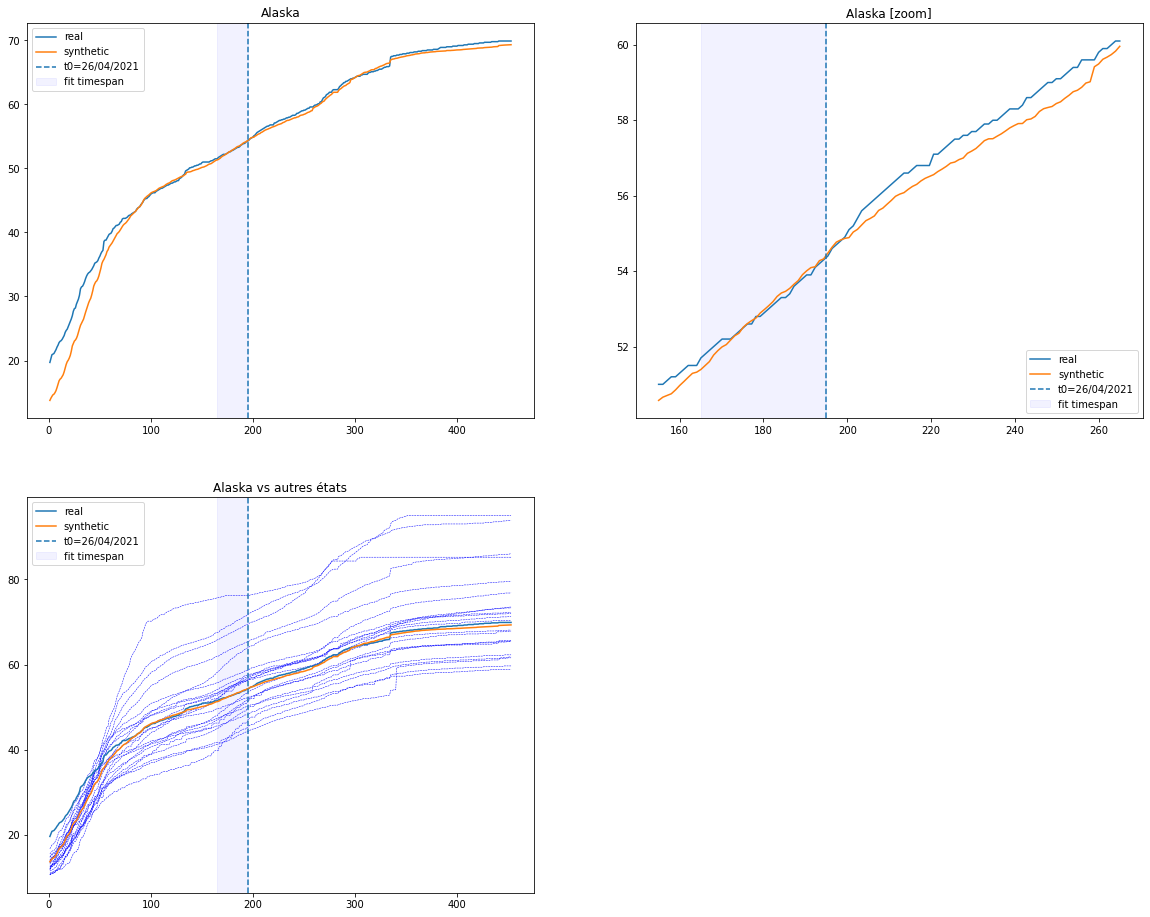


The state of Alabama is simulated with:
    Mississippi 64.4 %
    Montana 35.6 %


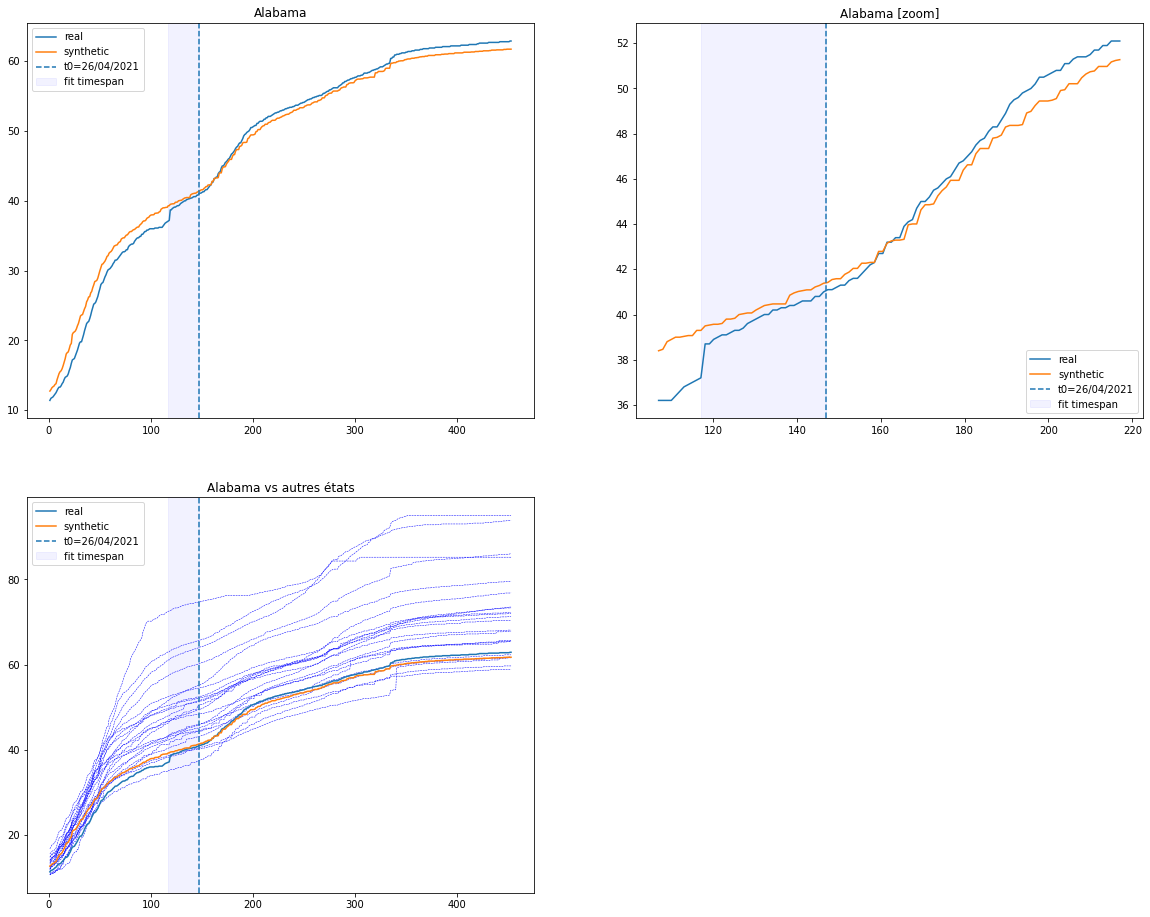


The state of Arkansas is simulated with:
    Tennessee 35.699999999999996 %
    Idaho 18.0 %
    North Dakota 16.400000000000002 %
    Mississippi 13.600000000000001 %
    Montana 12.2 %
    South Carolina 4.1000000000000005 %


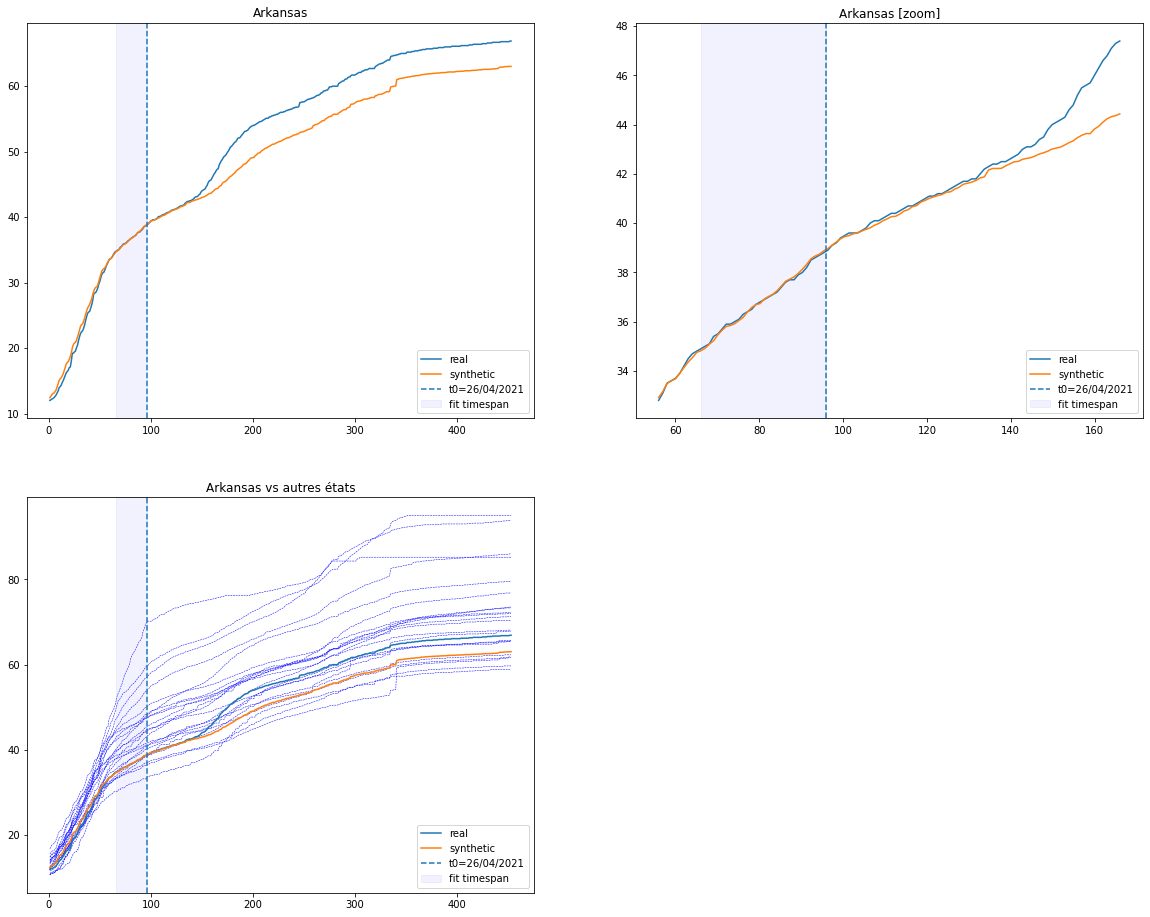


The state of California is simulated with:
    Florida 50.8 %
    Rhode Island 33.4 %
    Idaho 13.0 %
    Utah 2.3 %


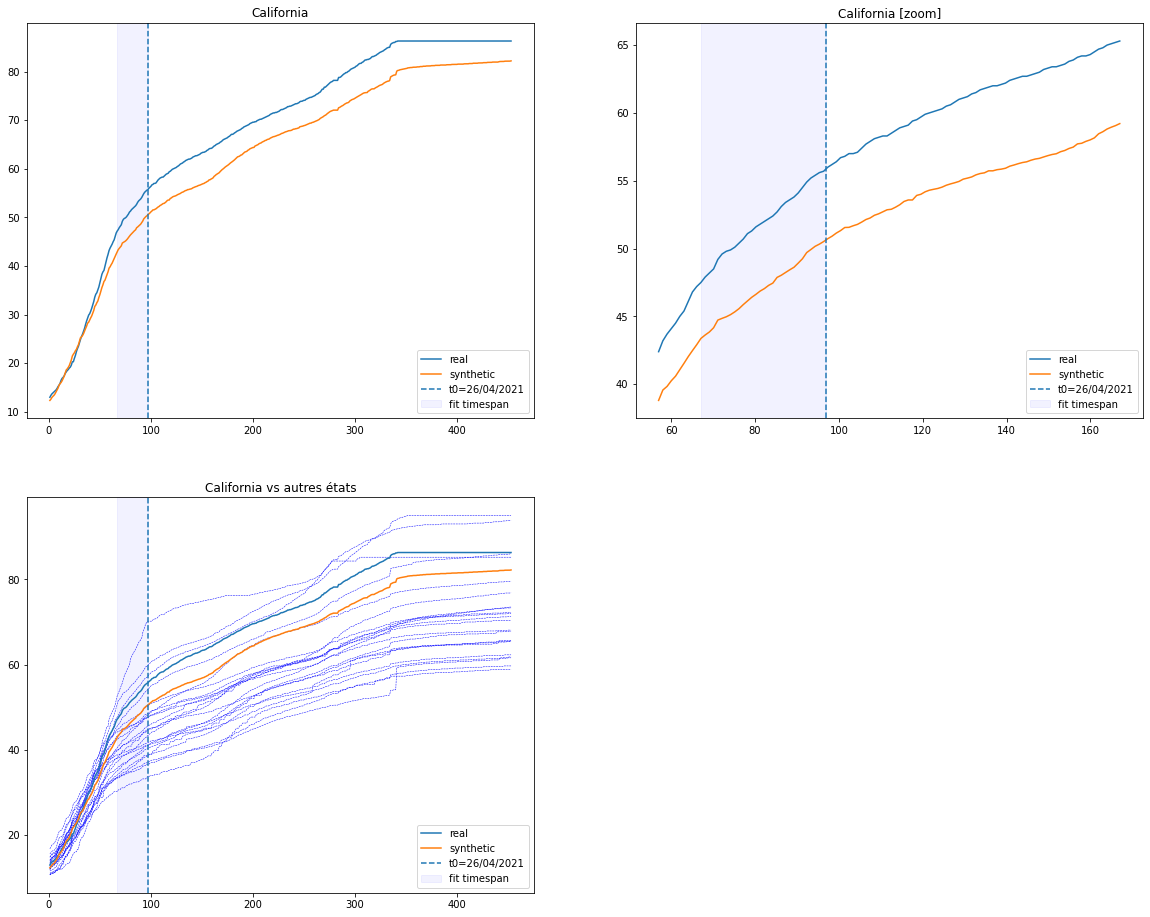


The state of Colorado is simulated with:
    Virginia 33.1 %
    Nebraska 18.3 %
    Vermont 14.299999999999999 %
    Pennsylvania 13.5 %
    Idaho 10.9 %
    Wisconsin 8.4 %
    South Carolina 1.6 %


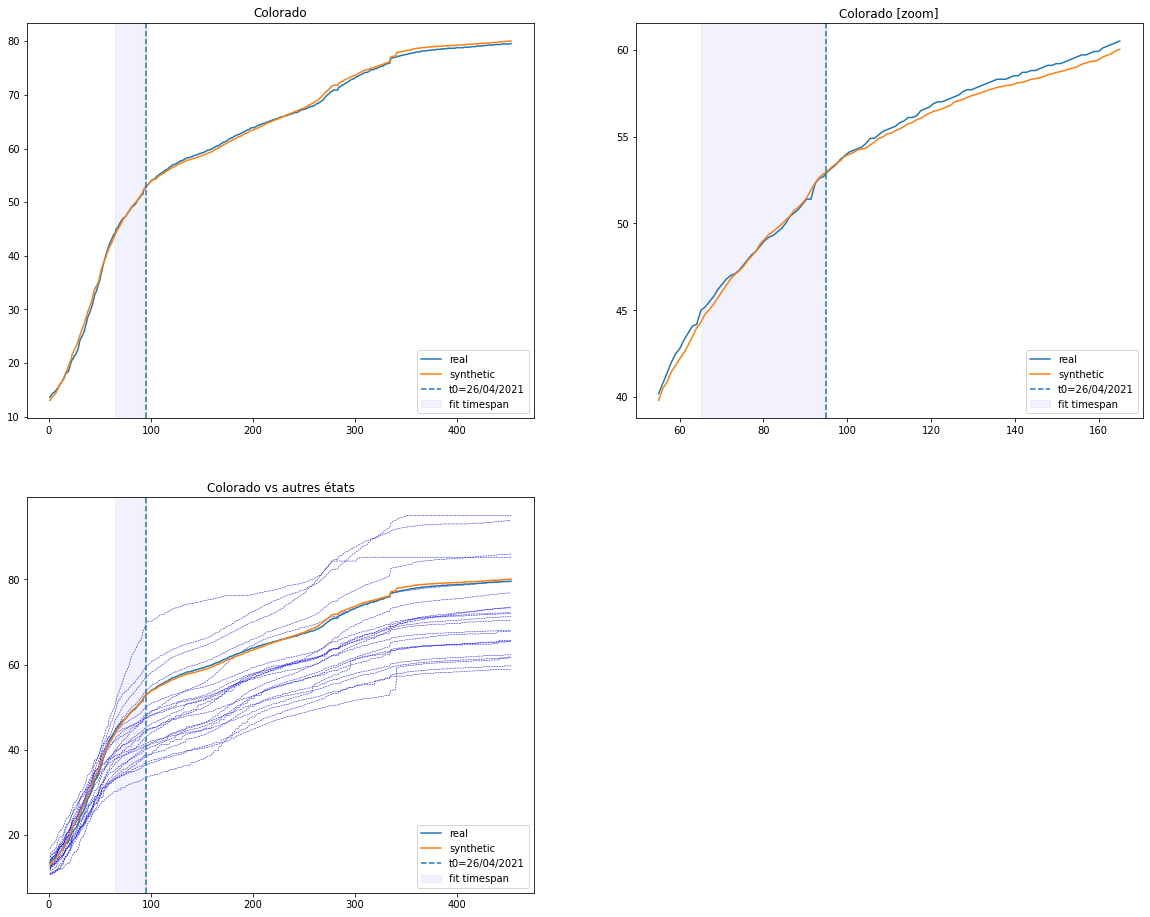


The state of Connecticut is simulated with:
    Nebraska 19.1 %
    Vermont 17.4 %
    South Carolina 10.0 %
    Rhode Island 9.3 %
    Florida 7.9 %
    Wyoming 7.3 %
    Wisconsin 6.3 %
    Pennsylvania 5.5 %
    Montana 5.4 %
    Idaho 3.8 %
    Oklahoma 2.6 %
    Indiana 2.3 %
    Mississippi 2.0 %


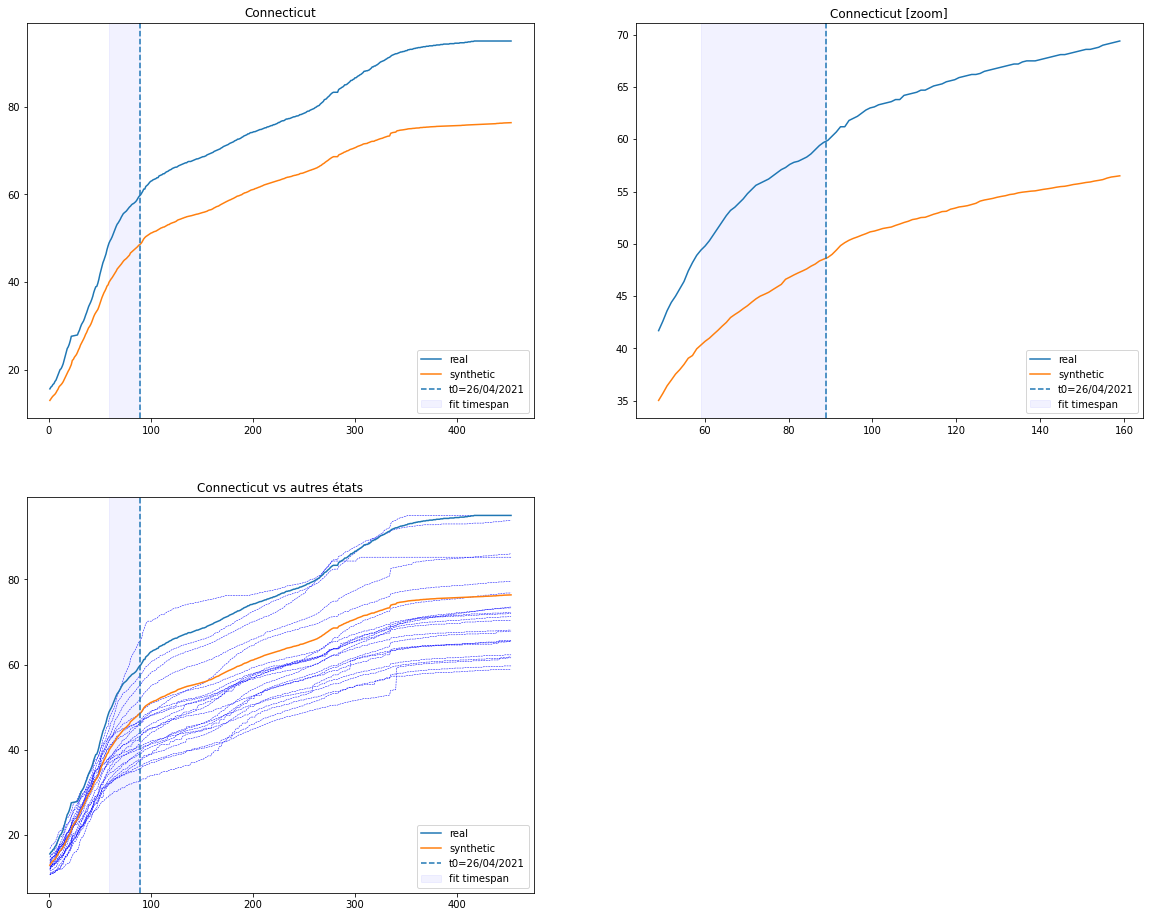


The state of Delaware is simulated with:
    Rhode Island 26.900000000000002 %
    South Dakota 23.200000000000003 %
    Florida 16.900000000000002 %
    Vermont 15.0 %
    South Carolina 10.4 %
    Idaho 2.8000000000000003 %
    Pennsylvania 1.9 %
    North Dakota 1.7999999999999998 %
    Wyoming 1.2 %


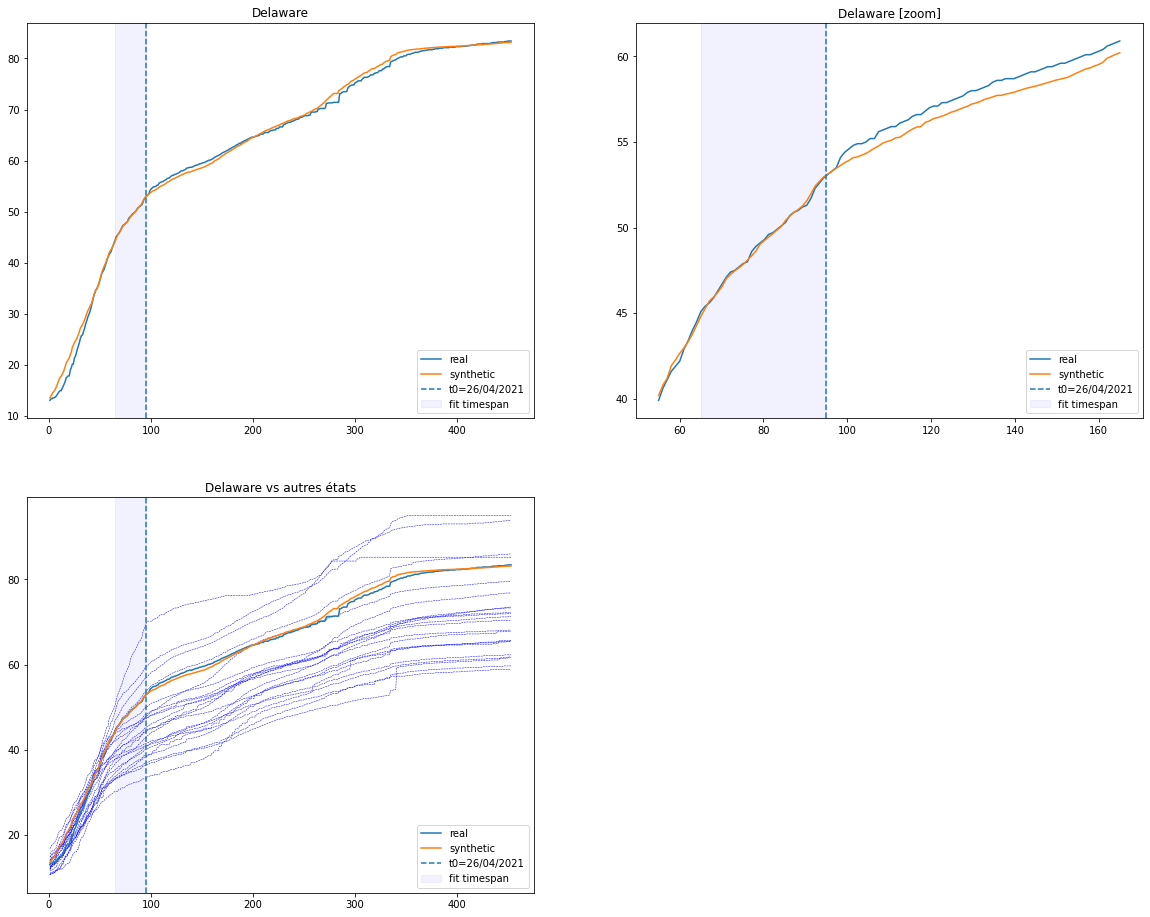


The state of Hawaii is simulated with:
    Vermont 55.00000000000001 %
    Wisconsin 22.8 %
    Idaho 10.7 %
    South Carolina 7.3999999999999995 %
    Pennsylvania 4.1000000000000005 %


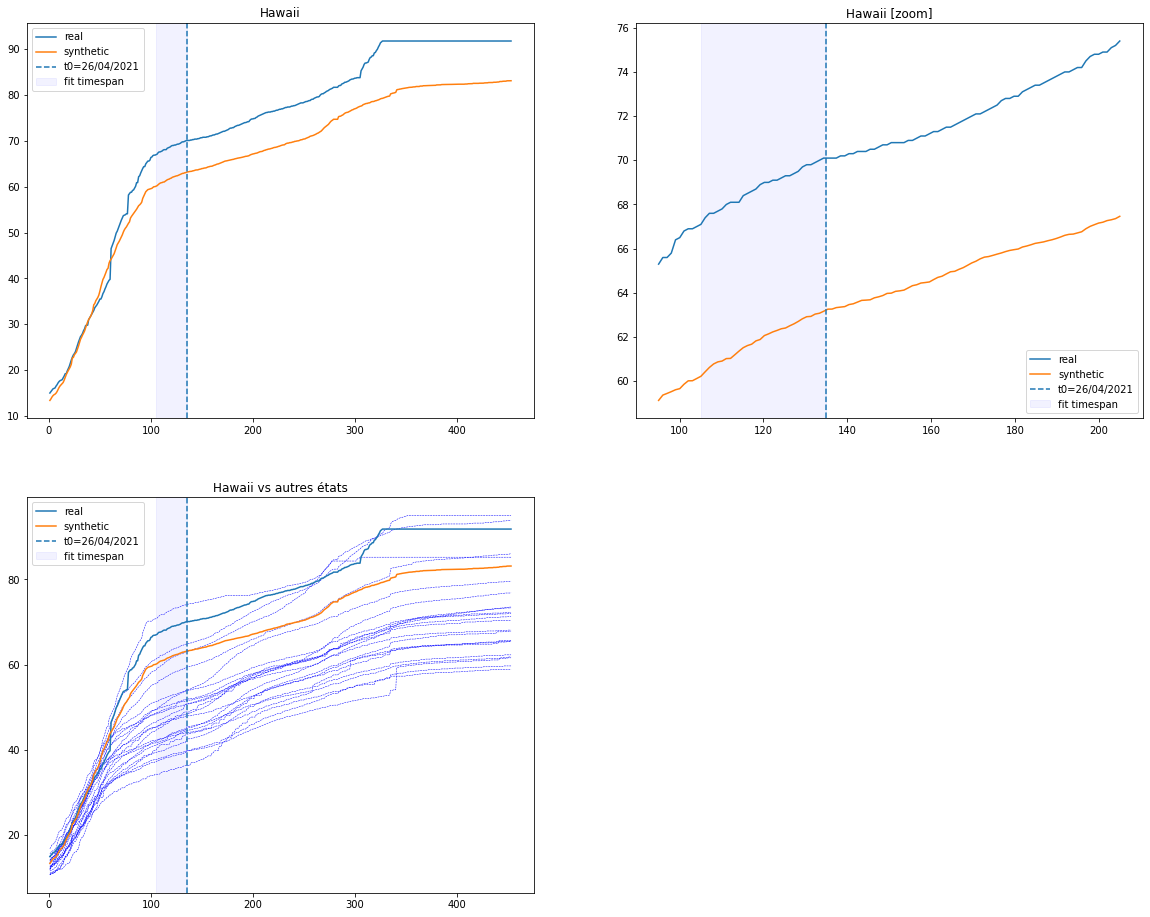


The state of Illinois is simulated with:
    Virginia 9.3 %
    Nebraska 8.6 %
    Indiana 7.7 %
    Vermont 7.7 %
    Wyoming 7.7 %
    Tennessee 7.7 %
    Iowa 6.800000000000001 %
    North Dakota 6.1 %
    Wisconsin 5.1 %
    Montana 4.7 %
    Pennsylvania 4.5 %
    Mississippi 4.0 %
    Oklahoma 3.8 %
    Rhode Island 3.2 %
    South Dakota 3.0 %
    Arizona 2.9000000000000004 %
    South Carolina 2.3 %
    Texas 1.5 %
    Idaho 1.3 %
    Utah 1.2 %
    Georgia 1.0 %


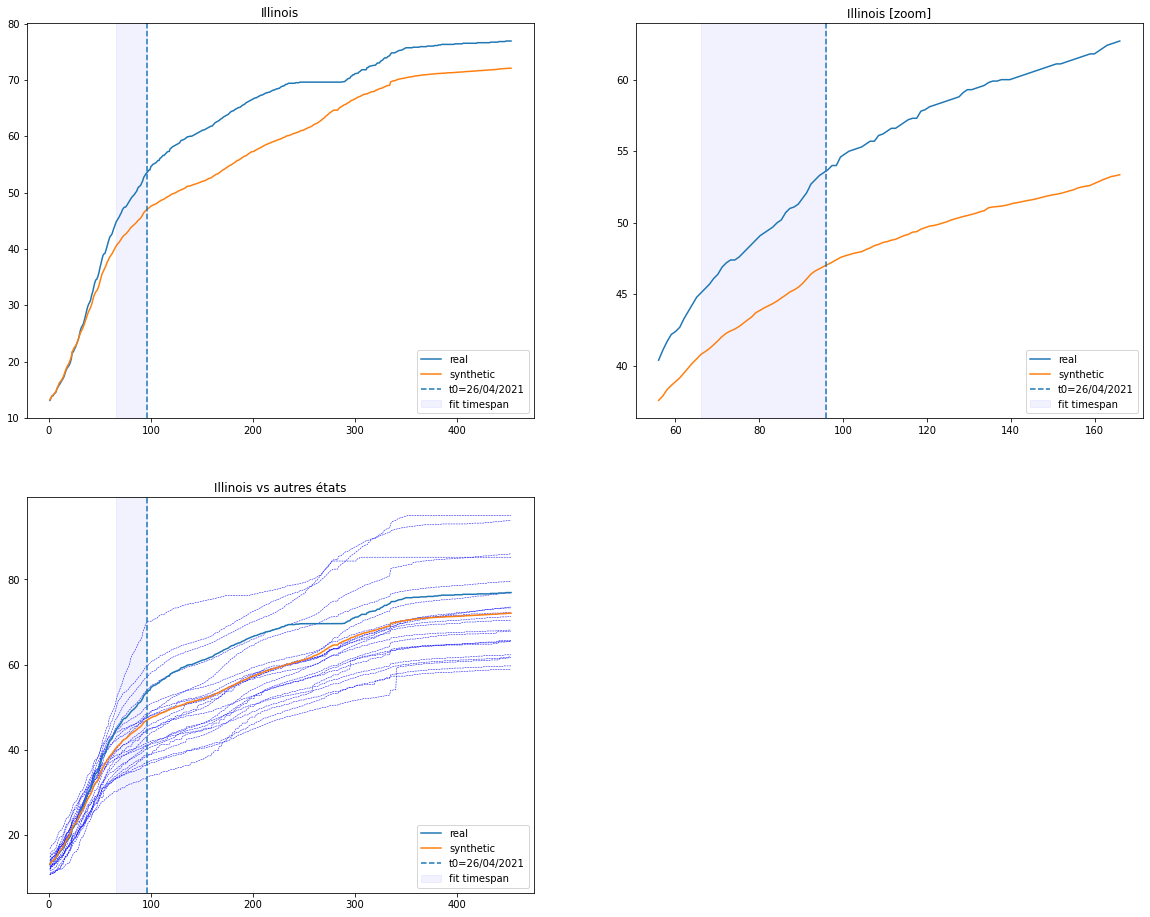


The state of Kansas is simulated with:
    Vermont 9.700000000000001 %
    Nebraska 9.0 %
    Wisconsin 8.3 %
    Idaho 7.6 %
    South Carolina 6.800000000000001 %
    Virginia 6.800000000000001 %
    Pennsylvania 6.800000000000001 %
    Montana 5.4 %
    Rhode Island 4.6 %
    Georgia 4.6 %
    Wyoming 3.9 %
    Utah 3.9 %
    Florida 3.8 %
    Mississippi 3.3000000000000003 %
    Tennessee 3.2 %
    Indiana 3.2 %
    South Dakota 2.5 %
    Iowa 2.4 %
    Oklahoma 2.4 %
    Texas 1.7000000000000002 %


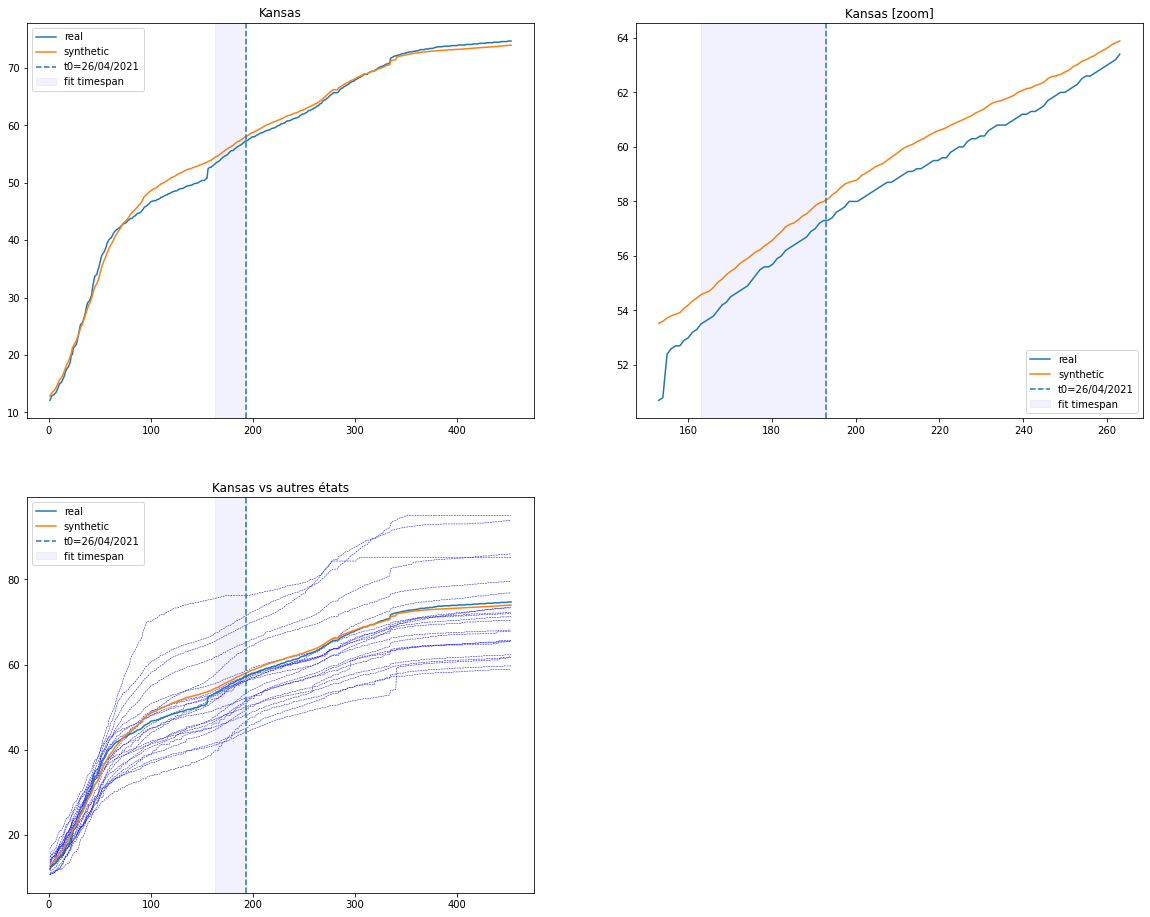


The state of Kentucky is simulated with:
    Arizona 23.1 %
    Rhode Island 15.0 %
    Wyoming 13.700000000000001 %
    Texas 10.8 %
    North Dakota 10.2 %
    South Carolina 5.800000000000001 %
    Pennsylvania 4.6 %
    Idaho 3.8 %
    Iowa 3.6999999999999997 %
    South Dakota 3.4000000000000004 %
    Tennessee 3.3000000000000003 %
    Mississippi 1.7000000000000002 %


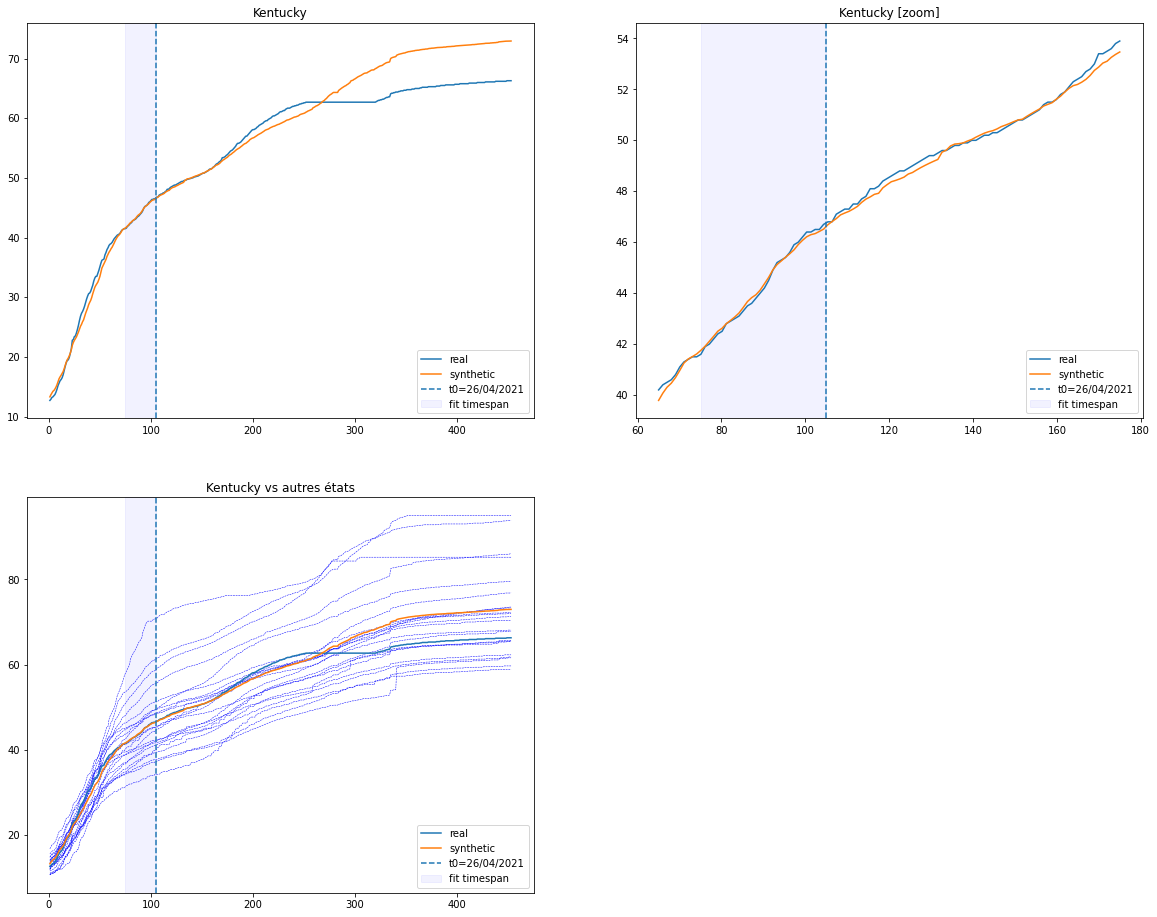


The state of Louisiana is simulated with:
    Mississippi 61.0 %
    North Dakota 30.4 %
    Arizona 8.6 %


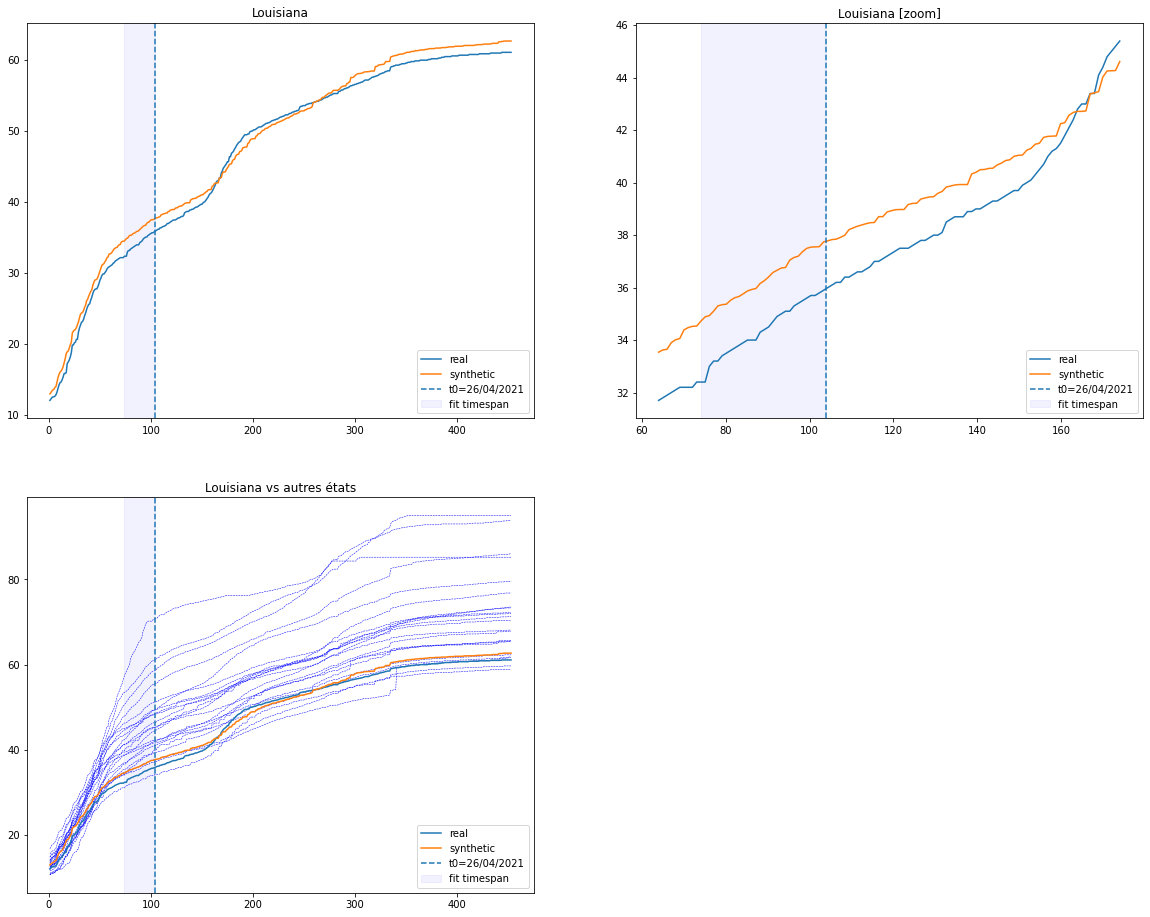


The state of Massachusetts is simulated with:
    Vermont 82.39999999999999 %
    Nebraska 17.599999999999998 %


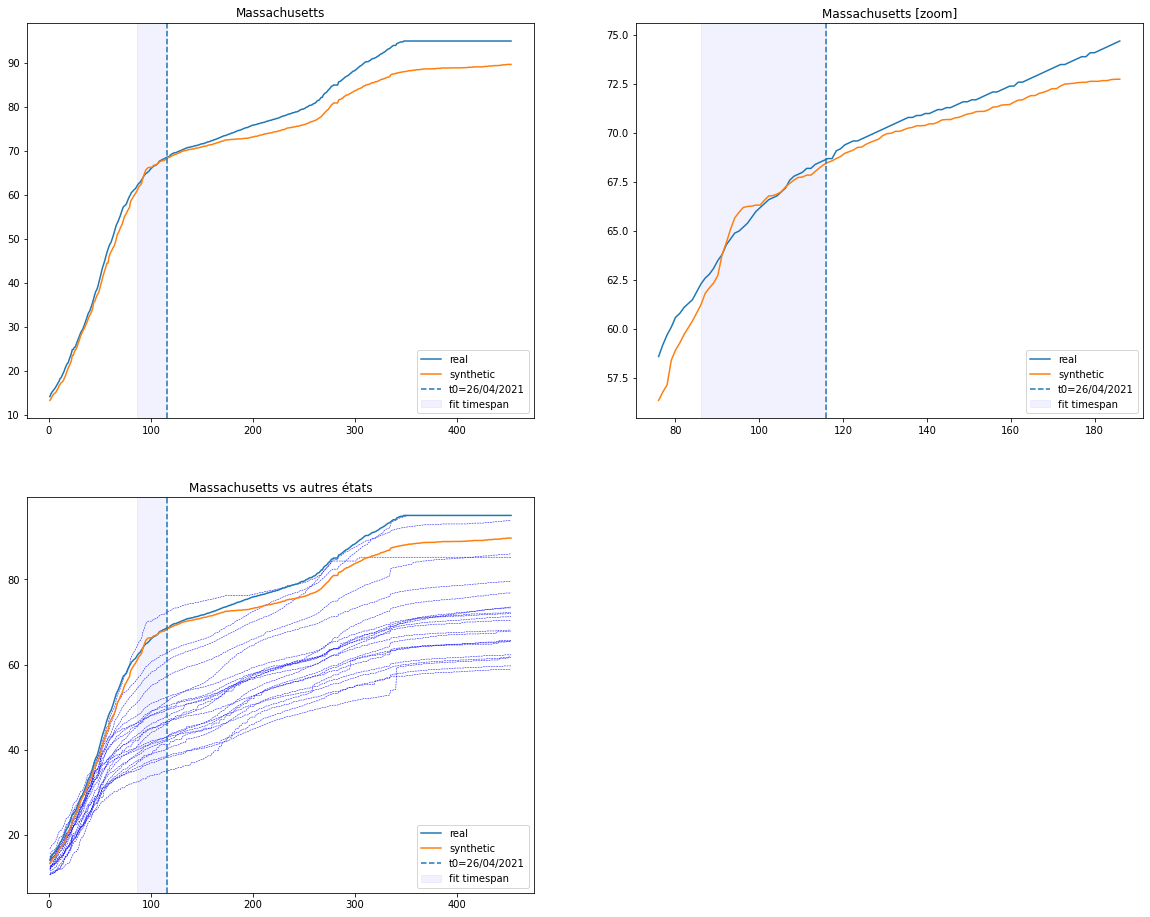


The state of Maryland is simulated with:
    Vermont 37.0 %
    Wisconsin 31.0 %
    Nebraska 29.299999999999997 %
    Idaho 2.6 %


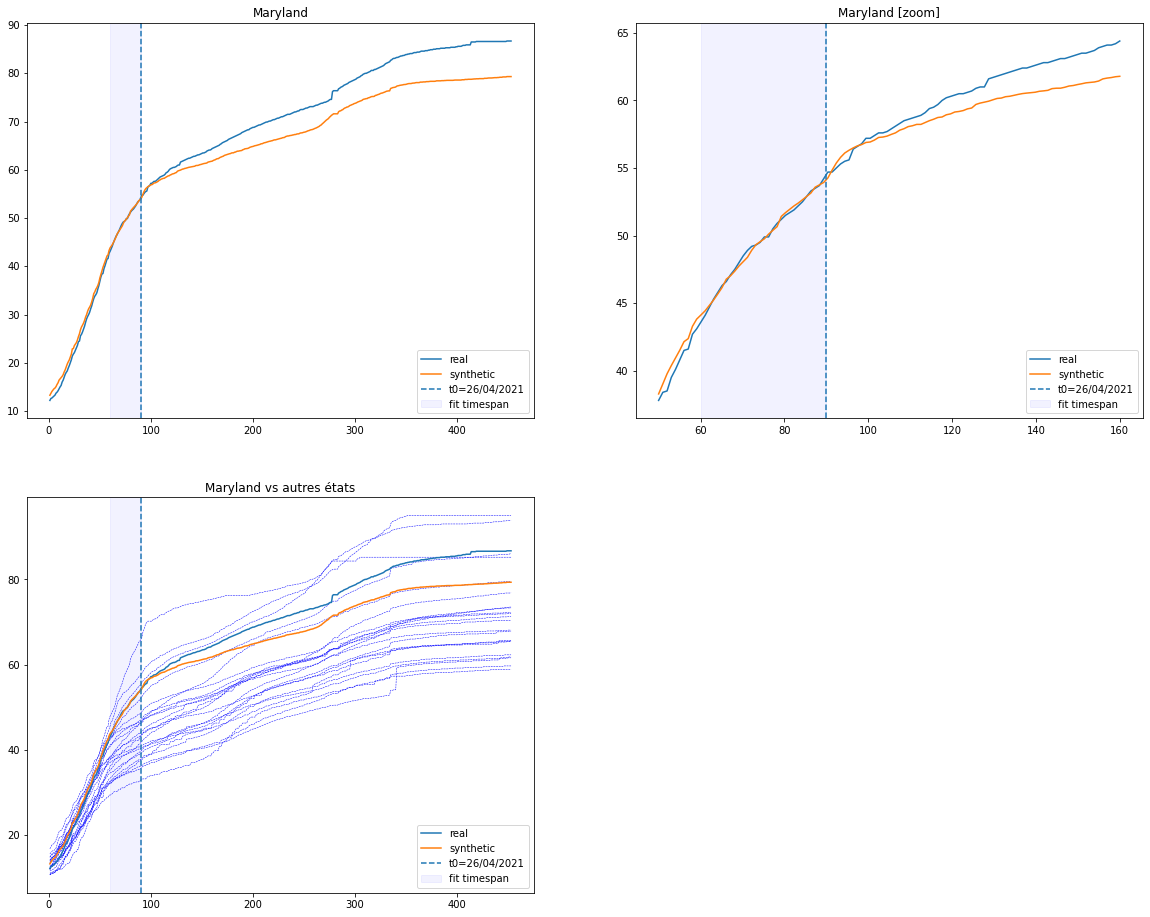


The state of Maine is simulated with:
    Vermont 52.0 %
    Wisconsin 21.9 %
    Virginia 16.5 %
    Pennsylvania 9.1 %


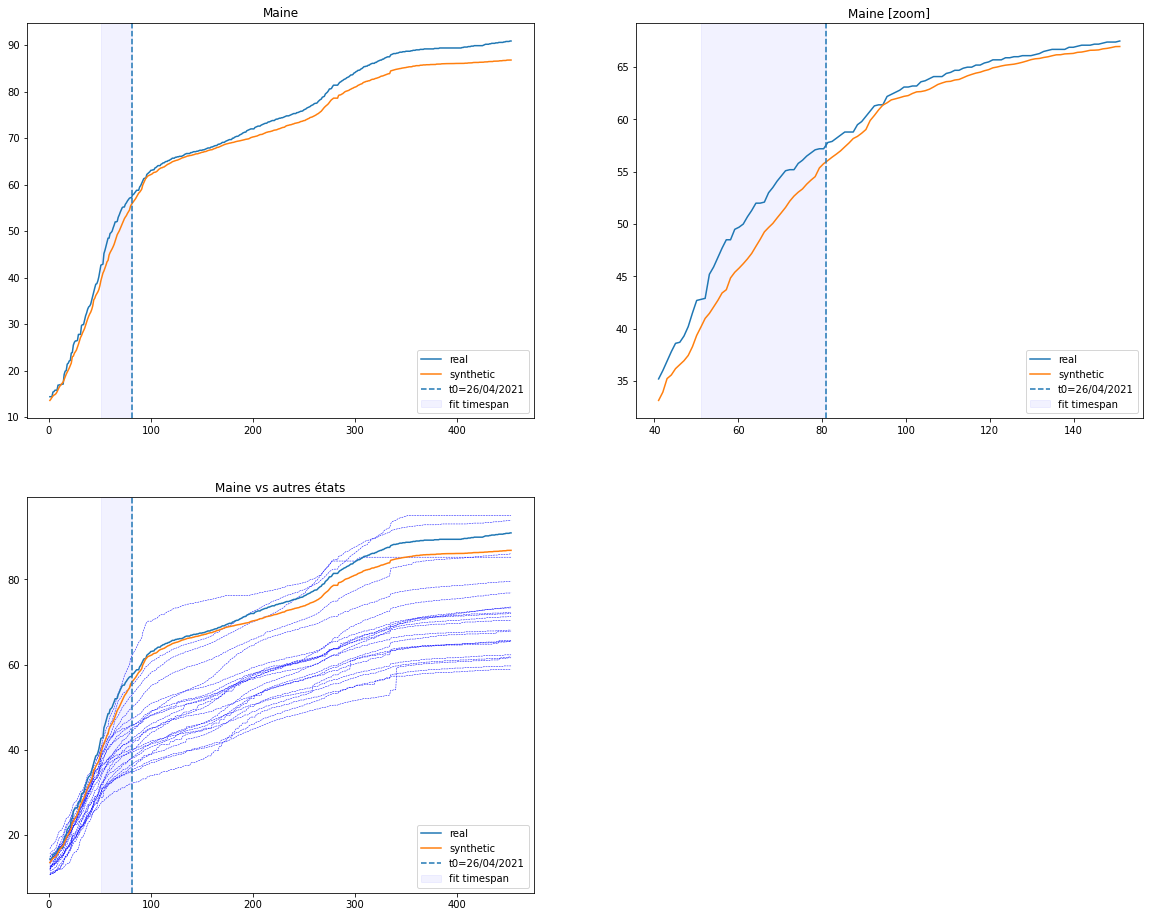


The state of Michigan is simulated with:
    Vermont 12.9 %
    Pennsylvania 8.4 %
    Wyoming 8.3 %
    Oklahoma 7.5 %
    Rhode Island 7.3 %
    Montana 7.000000000000001 %
    Indiana 6.800000000000001 %
    Mississippi 6.6000000000000005 %
    Idaho 6.4 %
    North Dakota 5.6000000000000005 %
    Wisconsin 4.7 %
    South Dakota 4.3 %
    Arizona 3.6999999999999997 %
    Georgia 2.9000000000000004 %
    Florida 2.9000000000000004 %
    Texas 2.5 %
    Iowa 2.1 %


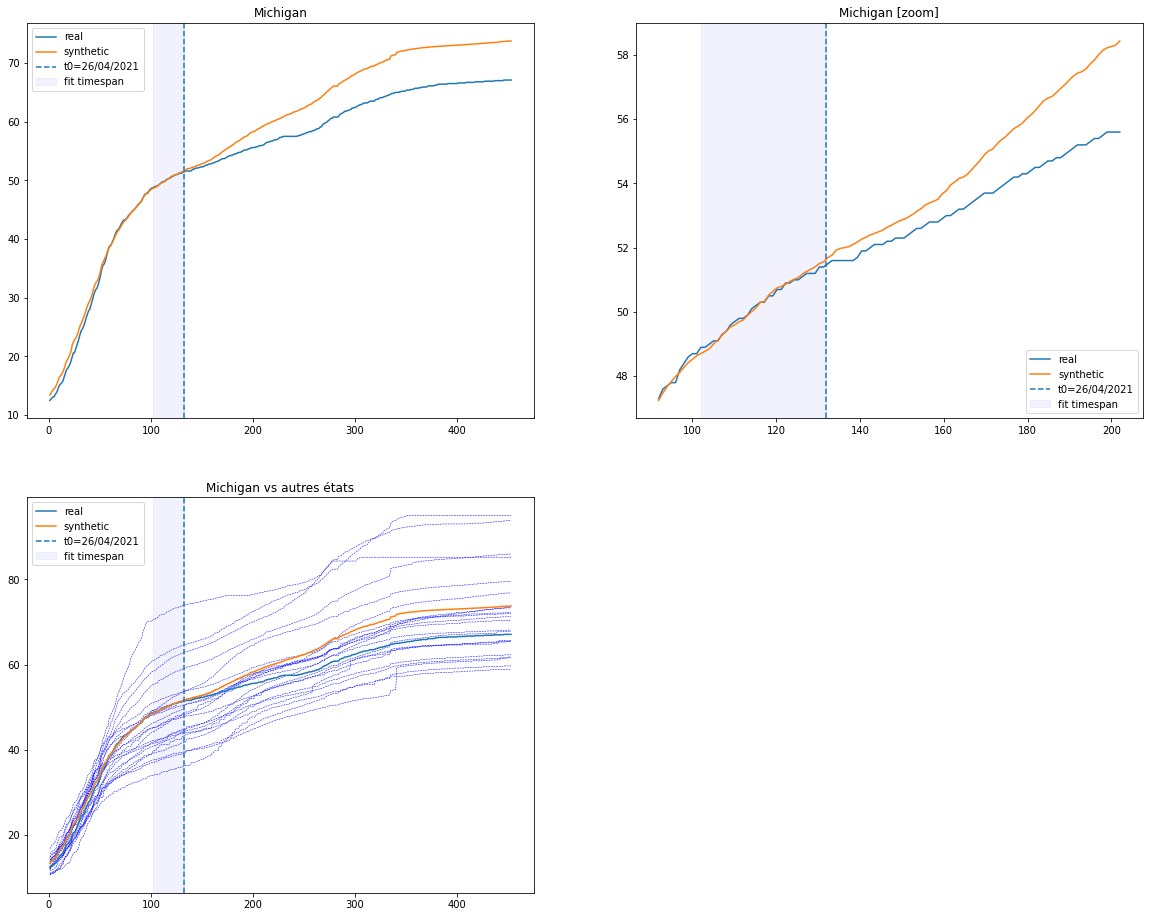


The state of Minnesota is simulated with:
    Wisconsin 38.800000000000004 %
    Nebraska 23.1 %
    Vermont 13.600000000000001 %
    Pennsylvania 11.700000000000001 %
    Virginia 8.799999999999999 %
    Rhode Island 1.7999999999999998 %
    Iowa 1.0999999999999999 %


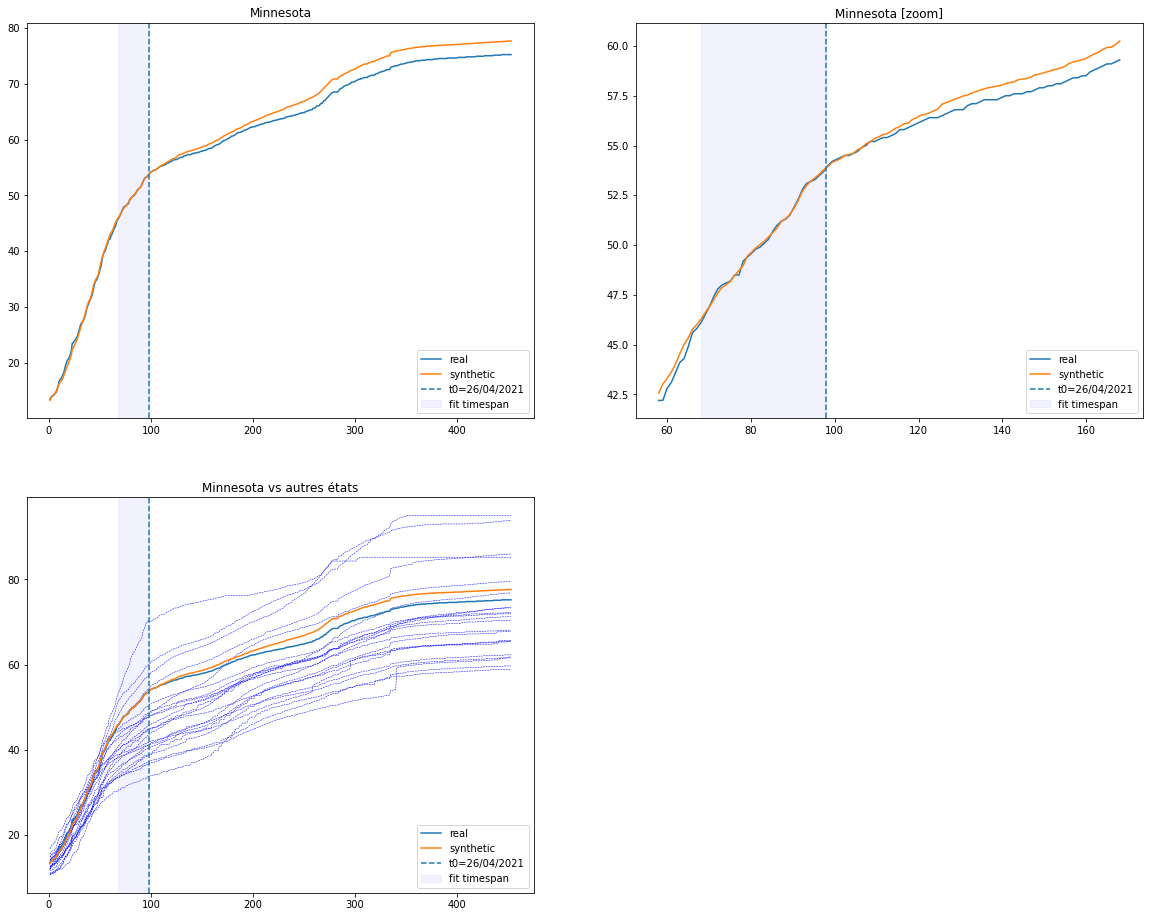


The state of Missouri is simulated with:
    Georgia 66.9 %
    North Dakota 16.7 %
    Florida 16.3 %


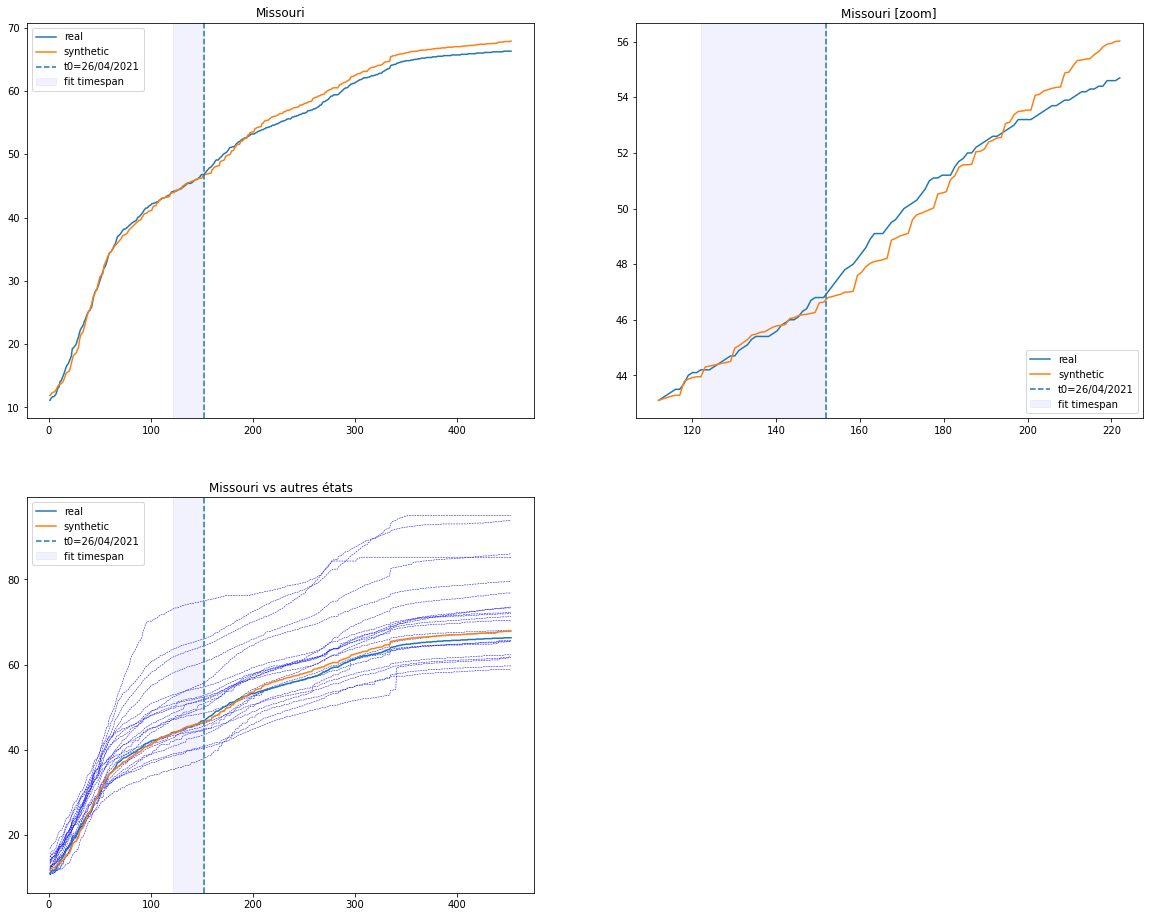


The state of North Carolina is simulated with:
    Nebraska 14.099999999999998 %
    Iowa 13.600000000000001 %
    Indiana 12.8 %
    Mississippi 11.0 %
    Virginia 9.8 %
    Wyoming 9.700000000000001 %
    South Carolina 9.6 %
    Tennessee 9.4 %
    Oklahoma 8.1 %
    Arizona 1.6 %


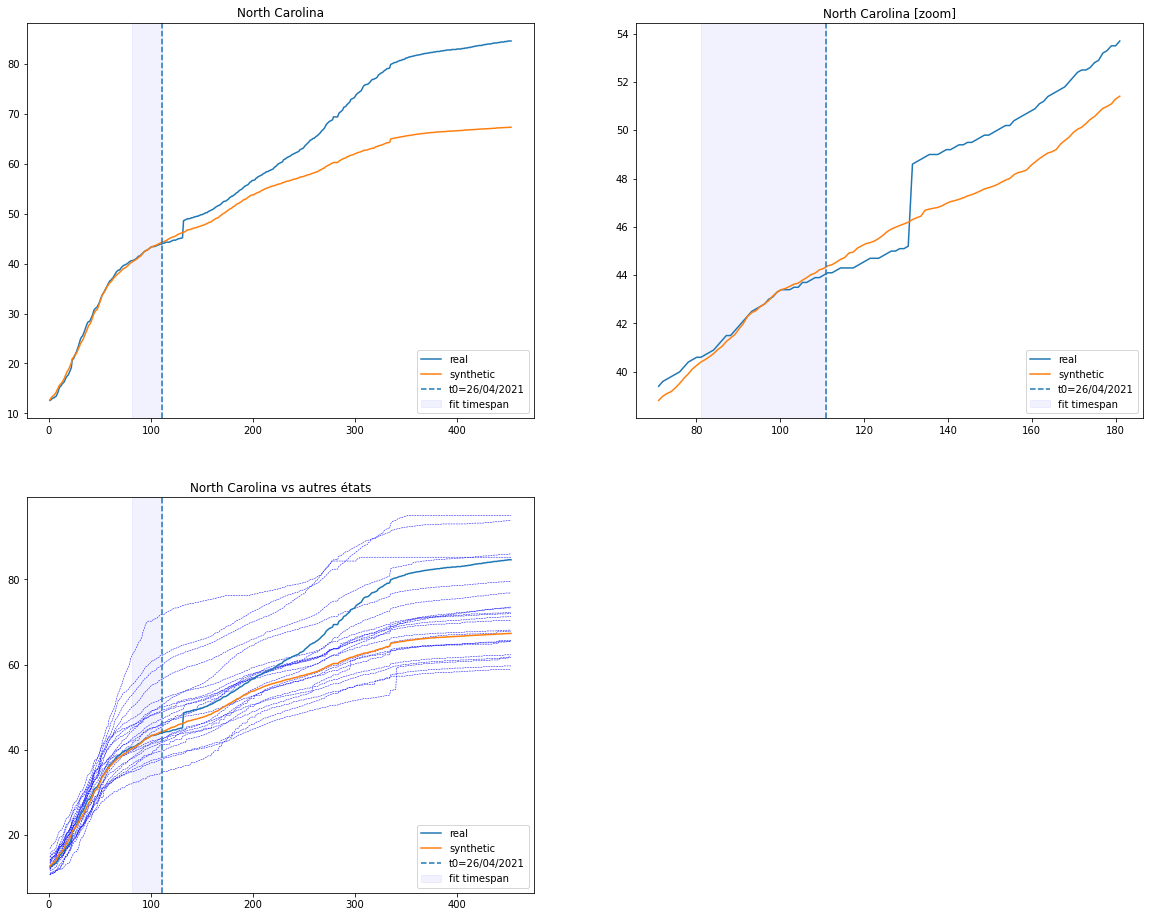


The state of New Jersey is simulated with:
    Wisconsin 7.1 %
    Idaho 6.6000000000000005 %
    Pennsylvania 6.3 %
    Rhode Island 6.2 %
    Utah 5.800000000000001 %
    Florida 5.7 %
    Virginia 5.6000000000000005 %
    Wyoming 5.5 %
    North Dakota 5.4 %
    Oklahoma 5.3 %
    Georgia 5.1 %
    Nebraska 5.1 %
    Texas 4.6 %
    Vermont 4.5 %
    South Dakota 4.3 %
    Indiana 4.2 %
    Mississippi 4.1000000000000005 %
    Iowa 3.2 %
    Arizona 3.0 %
    South Carolina 1.5 %


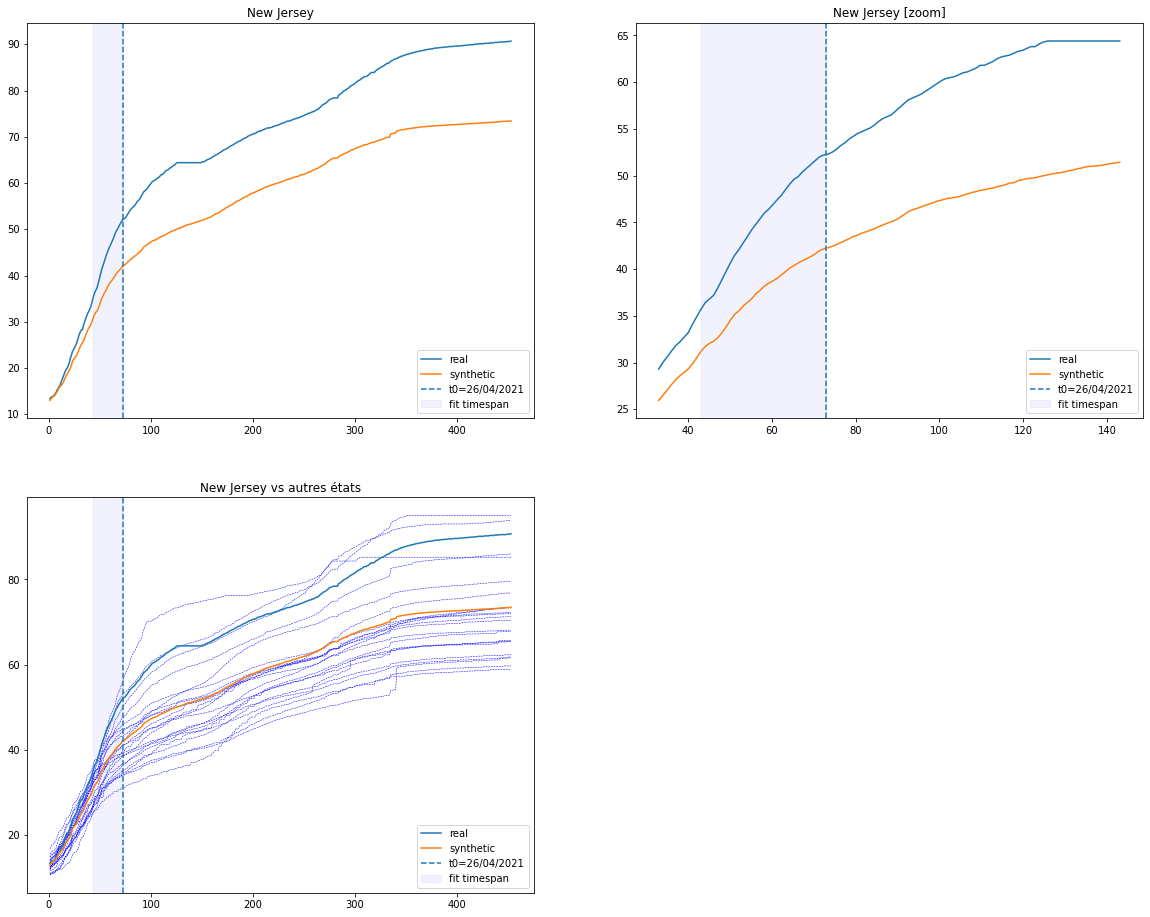


The state of New Mexico is simulated with:
    Pennsylvania 13.8 %
    Rhode Island 11.899999999999999 %
    North Dakota 10.7 %
    Florida 10.0 %
    Wyoming 9.9 %
    Idaho 9.5 %
    Wisconsin 8.9 %
    South Carolina 7.8 %
    Montana 7.5 %
    Vermont 7.000000000000001 %
    Nebraska 1.7000000000000002 %
    Mississippi 1.3 %


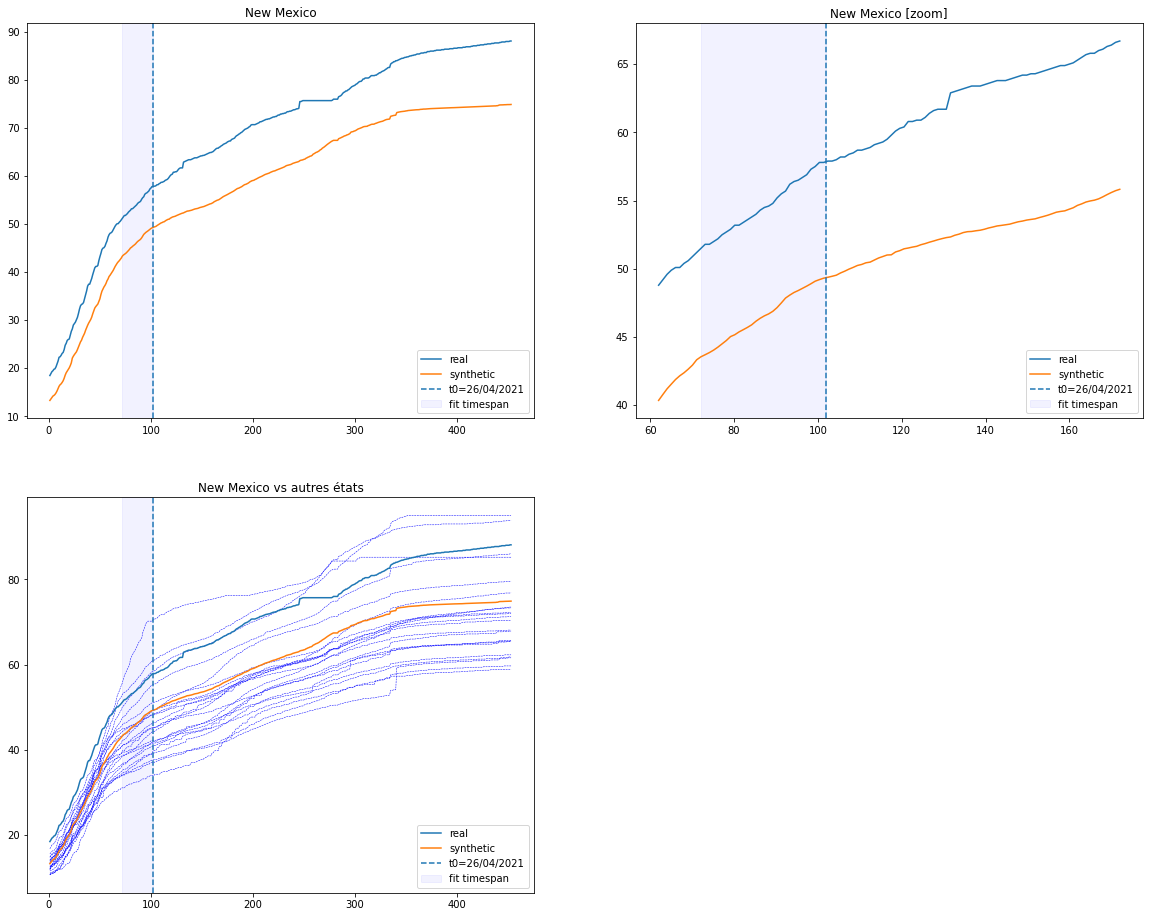


The state of Nevada is simulated with:
    Florida 47.699999999999996 %
    Utah 24.7 %
    Georgia 12.2 %
    Idaho 10.9 %
    South Carolina 4.5 %


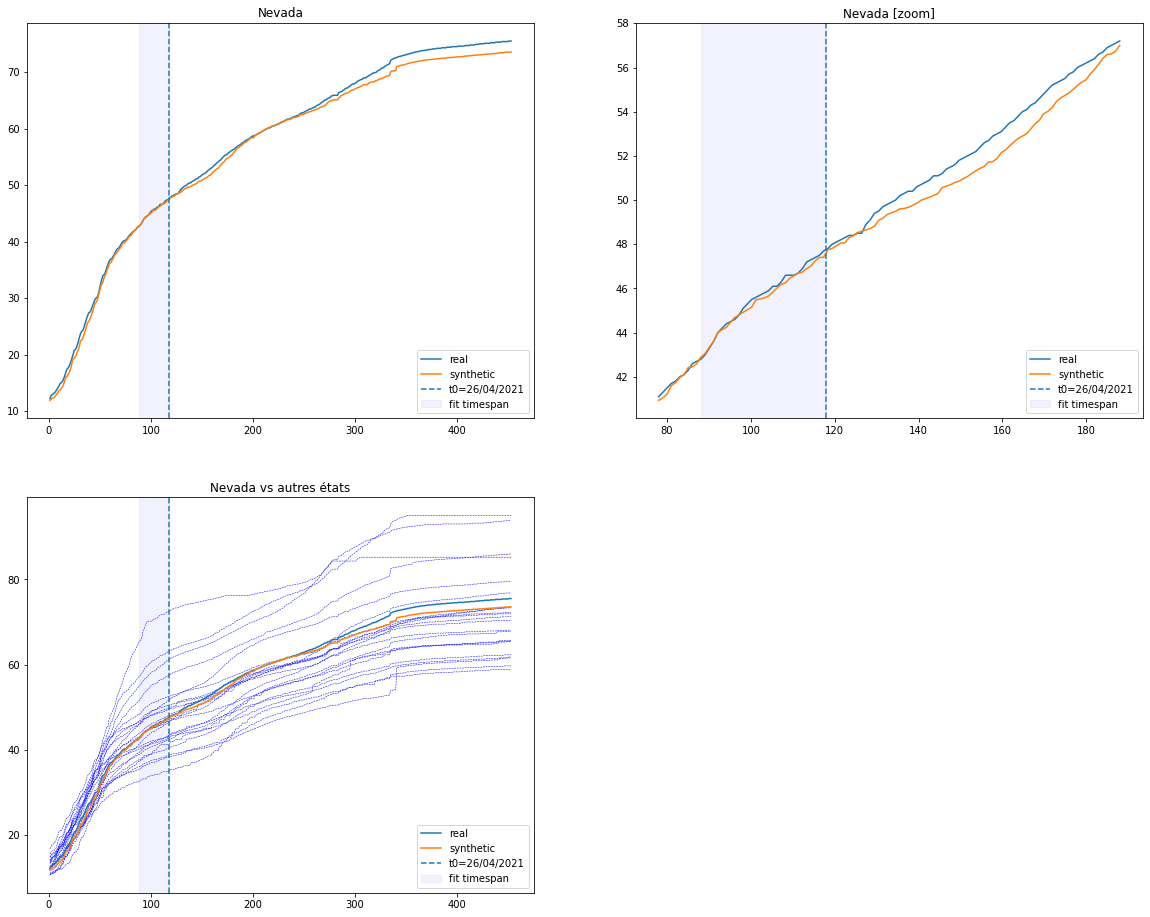


The state of New York is simulated with:
    Vermont 23.5 %
    Wyoming 22.2 %
    Rhode Island 20.5 %
    Wisconsin 20.1 %
    Pennsylvania 7.7 %
    Idaho 4.8 %
    Arizona 1.2 %


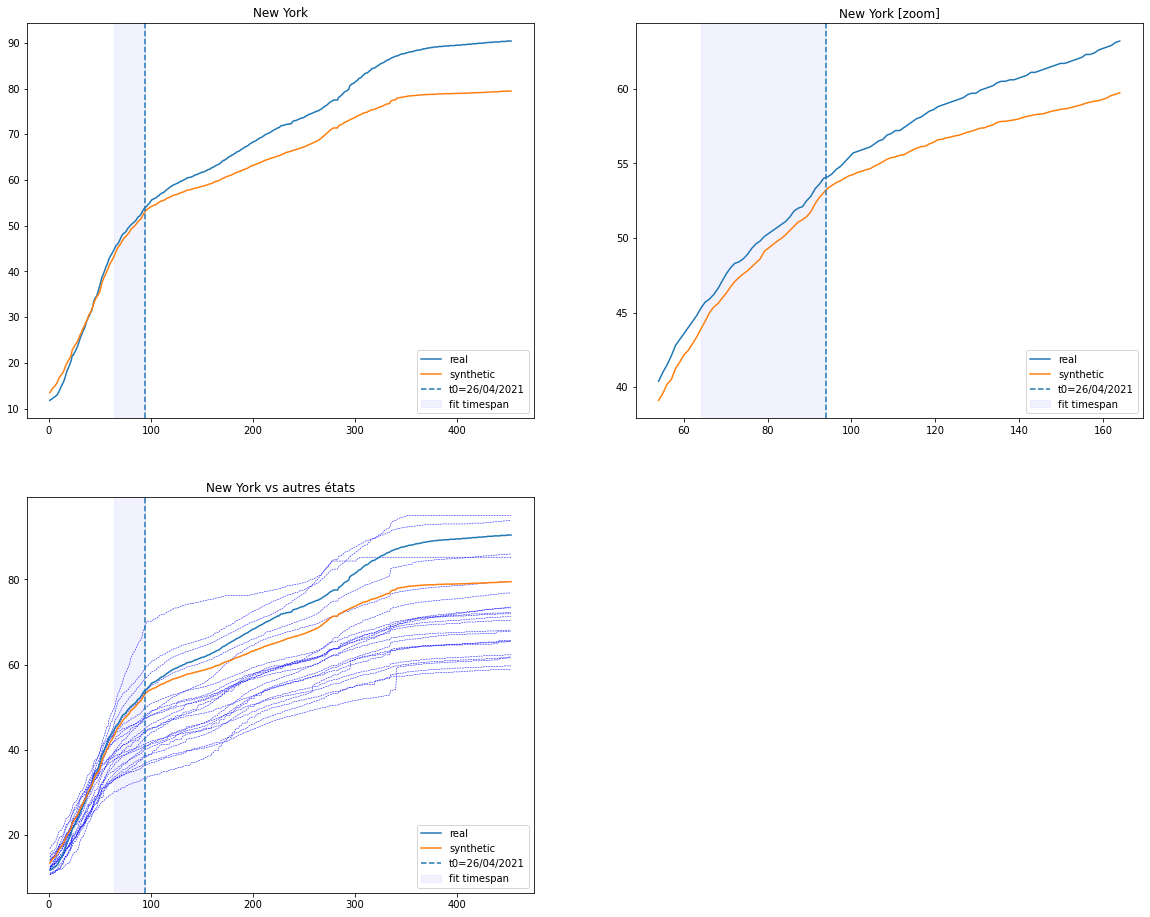


The state of Ohio is simulated with:
    Tennessee 29.2 %
    Nebraska 22.0 %
    Montana 19.5 %
    Iowa 18.5 %
    Wisconsin 8.9 %
    South Carolina 1.7999999999999998 %


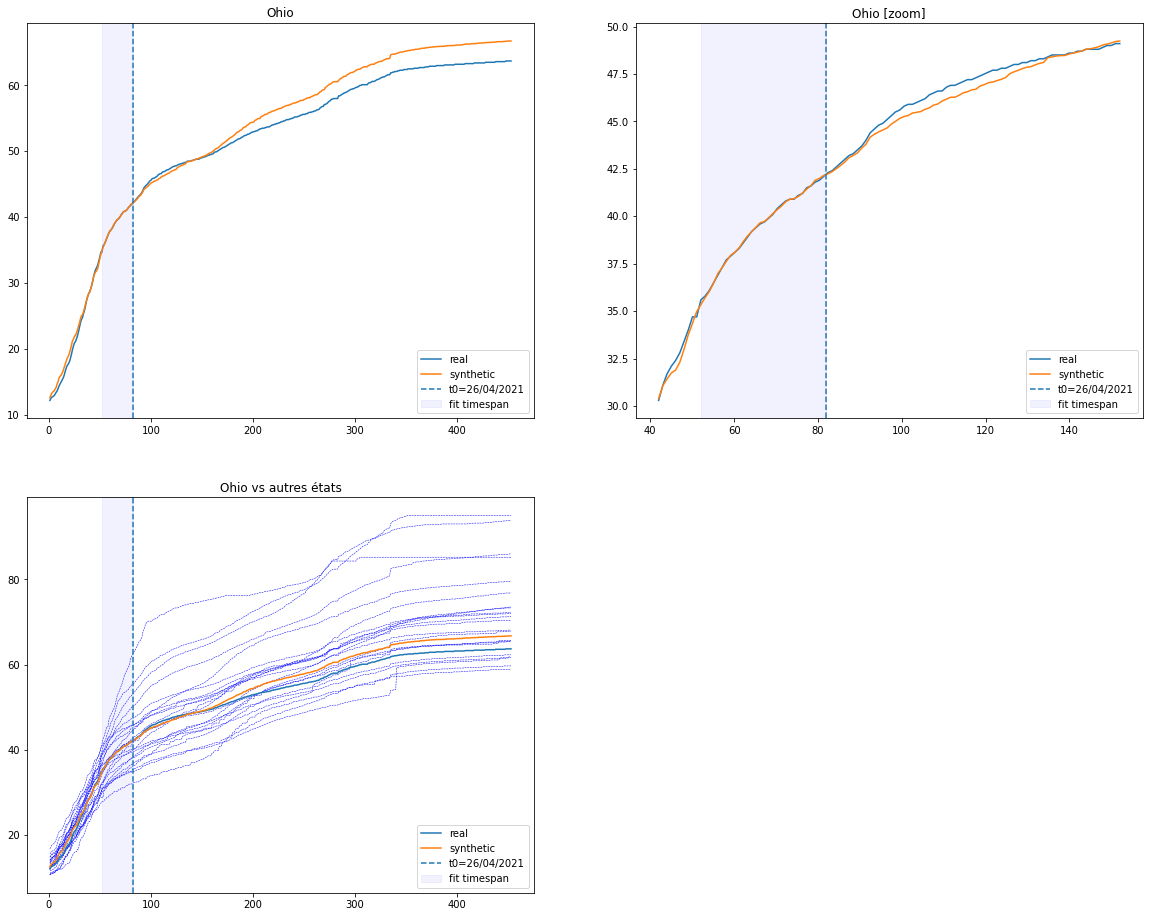


The state of Oregon is simulated with:
    Virginia 13.100000000000001 %
    Utah 8.6 %
    Iowa 7.6 %
    Tennessee 6.4 %
    Georgia 6.4 %
    Arizona 5.4 %
    North Dakota 5.3 %
    Indiana 5.2 %
    Idaho 5.1 %
    Wisconsin 5.1 %
    Texas 4.2 %
    Mississippi 4.2 %
    South Dakota 4.2 %
    Oklahoma 4.1000000000000005 %
    Pennsylvania 4.0 %
    Montana 3.1 %
    Wyoming 2.9000000000000004 %
    South Carolina 2.7 %
    Rhode Island 1.7000000000000002 %


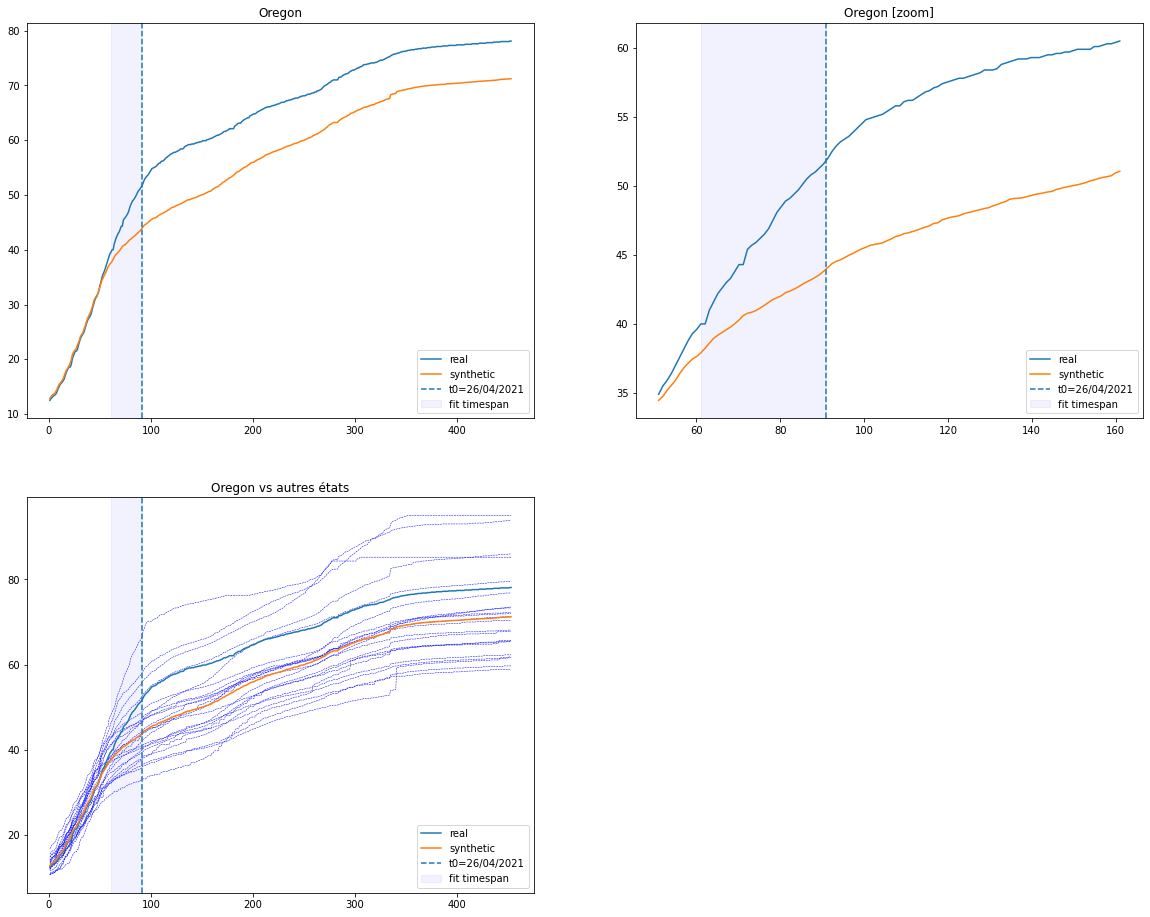


The state of Washington is simulated with:
    Vermont 42.6 %
    Idaho 21.9 %
    Nebraska 21.6 %
    Wisconsin 13.900000000000002 %


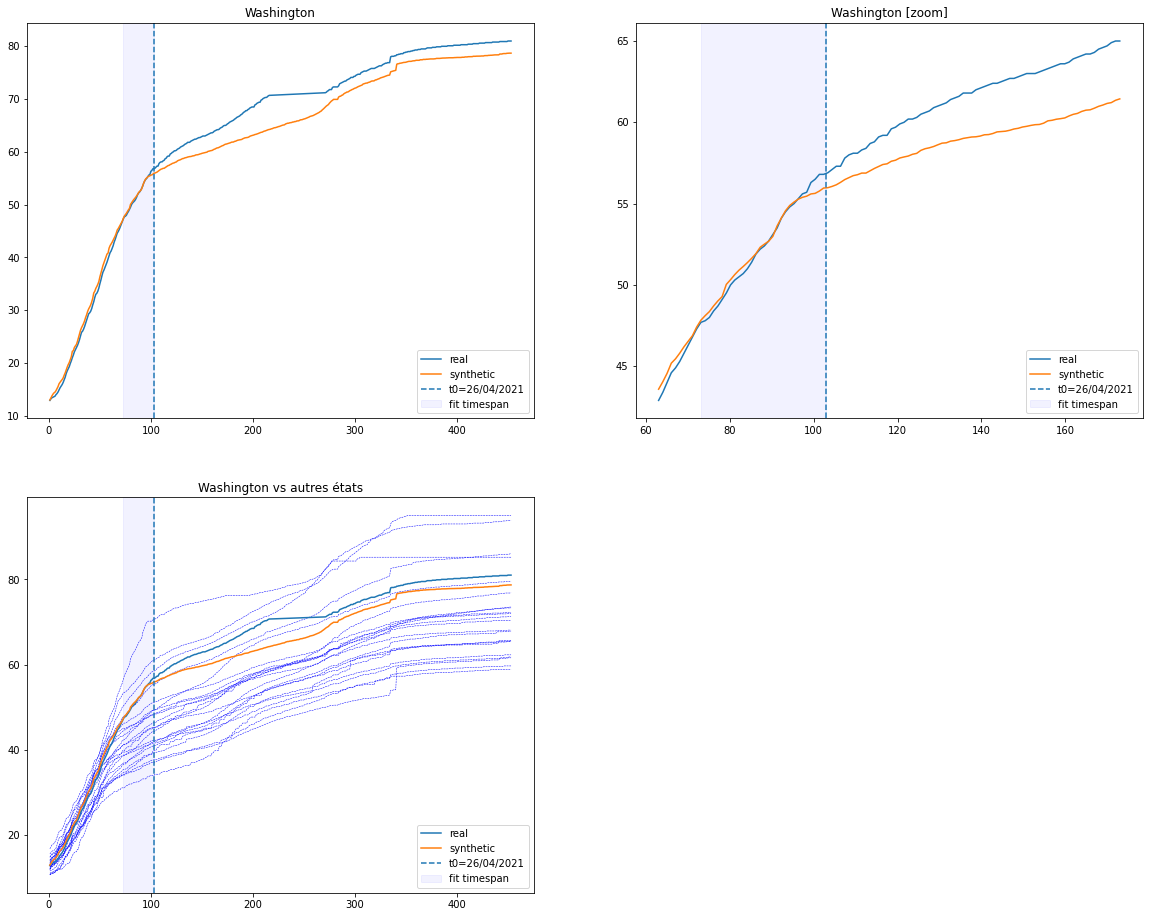


The state of West Virginia is simulated with:
    Arizona 36.5 %
    Mississippi 33.6 %
    South Dakota 21.0 %
    Tennessee 7.5 %
    Montana 1.4000000000000001 %


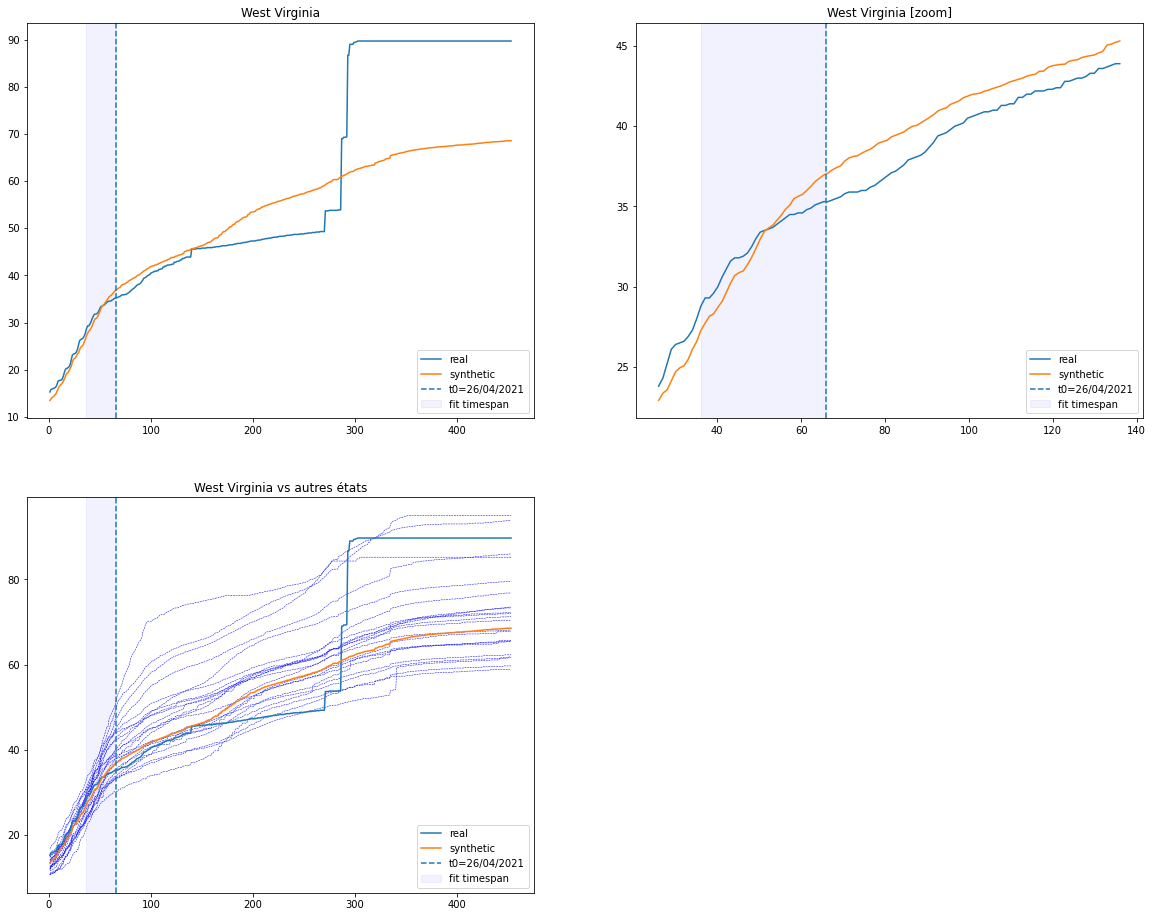

In [37]:
V = synthetic(ls_dose1, state_vector_scaled, t_fit=30, t_test=0, classe="Pop", plot=True)